In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 

k = 5 # Amount of topics
gamma = 0.05

In [3]:
# # GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
# D = 100 # Amount of documents
# V = 20 # Size of the vocabulary

# # (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# # To get the actual maximum amount, call Simulator.get_M
# M = 10 

# k = 10 # Amount of topics
# gamma = 0.05

## IMPORTANT: Please use static random seeds in **EVERY** cell where you use a random function, so that the result does **NOT** change at every run.

# 1. ARTIFICIAL DATA

### Task:

You must implement an algorithm that generates an artificial *corpus*, and return also a graph G and a correlation matrix Sigma.

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
#!pip install sklearn
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

In [5]:
# Transformation functions (deterministic)

def update_Theta(Theta, H):
    for d in range(D):
        Theta[d] = np.exp(H[d]) / np.sum(np.exp(H[d]), axis=0)
    print('Success: Theta transformed from H')
    return Theta

def update_E(E, Z):
    k = E.shape[1]
    for topic in range(k):
        E[:, topic] = np.sum(Z == topic, axis=2).sum(axis=1)
    print('Success: E transformed from Z')
    return E

def update_C(C, Z):
    k = C.shape[0]
    for topic in range(k):
        C[topic, :] = np.sum(Z == topic, axis=2).sum(axis=0)
    print('Success: C transformed from Z')
    return C

def update_B(B, C):
    # Note this is the transformation from C
    for topic in range(0, len(B)):
        B[topic] = C[topic] / sum(C[topic])
    print('Success: B transformed from C')
    return B

def update_Sigma(K):
    Sigma = np.linalg.inv(K)
    print('Success: Sigma transformed from K')
    return Sigma

In [6]:
# Random / Generating functions

def build_topic_distribution(seed):
    np.random.seed(seed)
    distribution = np.random.random(V)
    return distribution / distribution.sum()

def sample_B(seed):
    # B is the matrix whose rows are the distribution of topic i over the vocabulary
    # Each row means : for each topic i we have the probability of word i to occur
    # TODO: Change with Dirichlet prior -> See line to change
    b = np.empty((k,V))
    np.random.seed(seed)
    for i in range(k):
        b[i,:] = build_topic_distribution(seed)  # TODO: Change
    return b

def sample_G(k, gamma, seed):  # Won't update Sigma automatically anymore
    # Bernoulli for G
    # generate a random adjacency matrix
    np.random.seed(seed)
    matrix = np.array([[int(bernoulli.rvs(p=gamma, size=1)) for i in range(k)] for j in range(k)])
    for i in range(k):
        matrix[i][i] = 0
    for i in range(k):
        for j in range(k):
            matrix[j][i] = matrix[i][j]
    return matrix

def sample_K(k, seed):  # Won't update Sigma automatically anymore
    # I can build K for using make_sparse_spd_matrix from sklearn.datasets for example
    np.random.seed(seed)
    K = make_sparse_spd_matrix(k, alpha=0.95, norm_diag=False, smallest_coef=0.1, largest_coef=0.9, random_state=None)
    return K

def sample_H(Sigma, D, k, seed):  # Won't update Theta automatically anymore
    # Multivariate Normal
    mu = np.zeros(k)
    np.random.seed(seed)
    H = np.random.multivariate_normal(mu, Sigma, D)
    return H

def sample_Z_from_W(W, k, seed):
    D, V = W.shape
    M = int(W.max())
    Z = -np.ones((D, V, M))
    np.random.seed(seed)
    for d in range(D):
        for w in range(V): 
            occurrences = W[d, w]
            Z[d, w, 0:occurrences] = np.random.randint(0, k, size=occurrences)    
    return Z

In [7]:
# Main Simulator Class
class Simulator:
    
    # Remember we will have indexes starting from 0 so all max are -=1
    
    def __init__(self, D, V, M, k, gamma, seed):
        # Create zero matrices for all possible matrices
        self.W = np.zeros((D, V))  # matrix of D×V where Wdn is counter of appearances of the word n in document d
        self.B = np.zeros((k, V))  # matrix of kxV where Bz is the parameter vector of the distribution for the z-th topic
        self.C = np.zeros((k, V))  # matrix of kxV where Cz is the count vec of sampled topics over each word for all docs
        self.E = np.zeros((D, k))  # matrix of Dxk where Ed is the count vec of sampled drawings for topic z over all words for each doc
        self.H = np.zeros((D, k))  # H_d is eta_d
        self.Theta = np.zeros((D, k))  # This is just a transformation of H
        self.G = np.zeros((k, k))  # Adjacency Matrix (Check also python package "networkx" for graph objects!)
        self.K = np.zeros((k, k))  # Precision matrix of G
        self.Sigma = np.zeros((k, k))  # Inverse of K
        self.Z = -np.ones((D, V, M))  # Topic assignments for each words of each document
        self.D = D
        self.V = V
        self.M = M
        self.k = k
        self.gamma = gamma
        self.seed = seed  # Random seed

    # Generations
    def generate_WZ(self):
        if M == 0:
            raise Exception('Error: M value is 0')
        elif np.sum(self.Theta, axis=1).sum(axis=0) == 0:
            raise Exception('Error: Theta matrix 0')
        elif np.sum(self.B, axis=1).sum(axis=0) == 0:
            raise Exception('Error: B matrix 0')
        
        np.random.seed(self.seed)
        # Ref https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html
        # Multinomial drawing for Z and then W
        for d in range(self.D):
            
            # Maximum number of word drawings in the document            
            N_d = np.random.randint(1, int(self.M * self.V * 0.7))  # Hard-coding 70% thinning factor
            for n in range(N_d):
                
                # Multinomial drawing from Theta, because it has to be normalized
                # This will give a canonical vector over k
                mult = np.random.multinomial(1, self.Theta[d], size=1)  # This is a vector of 0's with a single 1
                z = np.argmax(mult)  # This is the index of the 1 (Topic index)
                
                # Multinomial drawing from Beta
                # This will give a canonical vector over V
                mult = np.random.multinomial(1, self.B[z], size=1)  # This is a vector of 0's with a single 1
                w = np.argmax(mult)  # This is the index of the 1 (Word index)
                
                empty_cell_indexes = np.nonzero(self.Z[d, w] == -1)[0]  # Check if there are still possible unassigned occurrences for this word
                if empty_cell_indexes.size != 0:  # At least one entry is not assigned
                    first_empty_index = empty_cell_indexes[0]
                    self.Z[d, w, first_empty_index] = z  # Assinging word to topic
                    self.W[d, w] += 1  # Increasing word counter
        
        print('Success: W and Z generated')
    
    # Transformations
    def update_Theta(self):
        self.Theta = update_Theta(self.Theta, self.H)
    
    def update_E(self):
        self.E = update_E(self.E, self.Z)
    
    def update_C(self):
        self.C = update_C(self.C, self.Z)
    
    def update_Sigma(self):
        self.Sigma = update_Sigma(self.K)
    
    # Initializing with real data
    # def save_W()
    
    # Priors
    def sample_B(self):
        self.B = sample_B(self.seed)
        
    def sample_GK(self):  # Here we can update Sigma automatically
        self.G = sample_G(self.k, self.gamma, self.seed)
        self.K = sample_K(self.k, self.seed)
        self.update_Sigma()
    
    def sample_H(self):  # Here we can update Theta automatically
        self.H = sample_H(self.Sigma, self.D, self.k, self.seed)
        self.update_Theta()
    
    def generate_all_data(self):
        # TODO: This should run all relevant methods one after the other in order to fully populate all data matrixes
        self.sample_B()  # Will get B
        self.sample_GK()  # Will get G, K, Sigma
        self.sample_H()  # Will get H, Theta from Sigma
        self.generate_WZ()  # Will get W, Z from Theta, B
        self.update_E()  # Will get E from Z
        self.update_C()  # Will get C from Z
        pass

## 1.1 Simulator Tests

In [8]:
test0 = Simulator(D, V, M, k, gamma, seed=1996)
test0.sample_GK()  # Will get G, K, Sigma
test0.sample_H()  # Will get H, Theta from Sigma
test0.sample_B()  # Will get B
test0.generate_WZ()
test0.update_E()

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z


In [9]:
test0.W

# NOTE:
# With M*D it's not really respected that M is the real max, just a desired one
# With 70% of that it's still not respected but closer
# With 50% of that it's respected in this case -> Could check if we can have real max M at some point

array([[ 3.,  1.,  5.,  8.,  1.,  9.,  4.,  8.,  5., 10.,  2.,  2.],
       [ 9.,  2.,  6.,  9.,  2.,  4.,  9.,  7., 10.,  7.,  5.,  2.],
       [ 2.,  0.,  0.,  2.,  0.,  1.,  1.,  2.,  2.,  2.,  0.,  0.],
       [ 2.,  0.,  3.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  2.,  2.,  3.,  2.,  0.,  0.],
       [ 9.,  0.,  3., 10.,  0.,  6.,  9.,  9., 10., 10.,  3.,  0.],
       [ 8.,  0.,  5.,  8.,  1.,  6., 10.,  6., 10., 10.,  0.,  1.],
       [ 5.,  1.,  3.,  2.,  0.,  2.,  4.,  3.,  4.,  6.,  1.,  0.]])

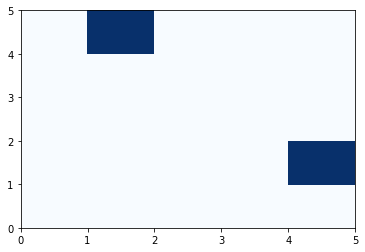

In [10]:
plt.pcolor(pd.DataFrame(test0.G) > 0.5, cmap='Blues')
plt.show()

In [11]:
# All in one function
test1 = Simulator(D, V, M, k, gamma, seed=1979)
test1.generate_all_data()
test1.W

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


array([[ 1.,  1.,  2.,  0.,  0.,  2.,  2.,  1.,  1.,  1.,  0.,  3.],
       [ 0.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  3.,  5.,  2.,  8.,  1.,  3.,  8.,  5.,  3.,  0.,  5.],
       [ 6.,  5.,  7.,  1.,  6.,  3.,  4.,  3.,  5.,  3.,  1., 10.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  3.,  0.,  4.,  3.,  0.,  1.,  2.,  4.,  2.,  5.],
       [ 5.,  2.,  2.,  0.,  5.,  1.,  5.,  1.,  9.,  3.,  3.,  3.]])

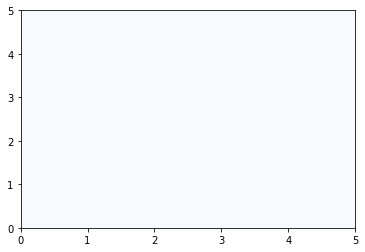

In [12]:
plt.pcolor(pd.DataFrame(test1.G) > 0.5, cmap='Blues')
plt.show()

In [13]:
# Confirming that with the same seed and input parameters, data generated are the same
test2 = Simulator(D, V, M, k, gamma, seed=1979)
test2.generate_all_data()
assert np.all(np.equal(test1.W, test2.W))  

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


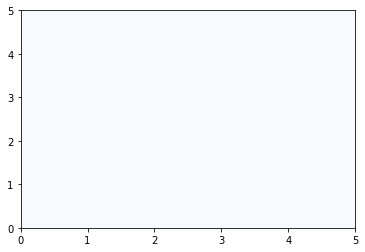

In [14]:
plt.pcolor(pd.DataFrame(test2.G) > 0.5, cmap='Blues')
plt.show()

From now on let's use the following simulated data for further testing

In [15]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

# Problem: We need at least matching Ws (?)
# Shouldn't we generate the random initial data starting from W?
# random_initial_data.W = test_data.W
# random_initial_data.Z = sample_Z_from_W(test_data.W, k, seed=1969)
# ...

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


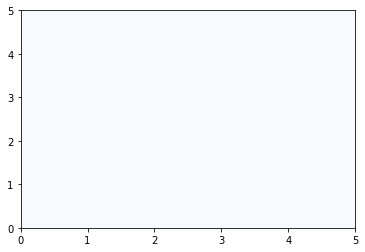

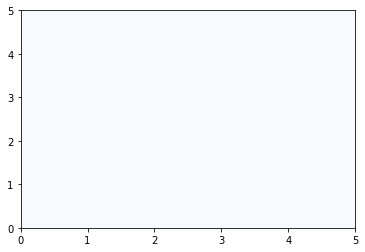

In [16]:
plt.pcolor(pd.DataFrame(test_data.G) > 0.5, cmap='Blues')
plt.show()

plt.pcolor(pd.DataFrame(random_initial_data.G) > 0.5, cmap='Blues')
plt.show()

# Problem: We should have something here -> Propose to change to 0.1 at least for the real data

# 2 MC SAMPLER

## 2.1.1 MCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $\Theta_{i+1}$ and $B_i$ and generates the next $Z_{i+1}$ and $B_{i+1}$.

In [27]:
def binary_search(sequence, item):
    begin_index = 0
    end_index = len(sequence)-1
    
    if sequence[begin_index] <= item and item <= sequence[end_index]:
        while begin_index < end_index - 1:  # Finish when the list has 2 items: Begin and end
            midpoint = (end_index + begin_index) // 2
            midpoint_value = sequence[midpoint]
            if midpoint_value < item:
                begin_index = midpoint
            else:
                end_index = midpoint
        if sequence[begin_index] == item:
            return begin_index + 1
        elif item <= sequence[end_index]:
            return end_index
    else:
        return -1

In [28]:
def MC_sample_Z(Z, W, Theta, B, E, C):  # D, k are global variables
    for d in range(D):
        for v in range(V):
            I_di = int(W[d, v])
            for j in range(I_di):
                z_hat = int(Z[d, v, j])
                
                if z_hat != -1:  # Bug fix: Took invalid topics and assigned them
                
                    E[d, z_hat] = max(0, E[d, z_hat]-1)

                    C[z_hat, v] = max(0, C[z_hat, v]-1)

                    Rho = []  # Needs to start from zero to have the interval to fall into topic 1
                    Rho_z = 0
                    Rho.append(Rho_z)

                    for z in range(k):
                        # Compute the denominator sum
                        C_vk = 0
                        for b in range(V):
                            if b != v:
                                C_vk += C[z, b]
                        # Compute the upper limits of the topic probabilities
                        d_part = E[d, z] + Theta[d, z]
                        z_part = C[z, v] + B[z, v]
                        denom = C_vk + V * B[z, v]
                        Rho_z += d_part * z_part / denom
                        Rho.append(Rho_z)

                    #print('Old topic: '+str(z_hat)+' search in: '+str(Rho))

                    u = np.random.uniform(0, Rho[-1])
                    z_hat = binary_search(Rho, u) - 1

                    E[d, z_hat] += 1
                    C[z_hat, v] += 1
                    Z[d, v, j] = z_hat

                    #print('New topic: '+str(z_hat)+', counter by doc: '+str(E[d, z_hat])+', counter by topic: '+str(C[z_hat, v]))

    # Note that we directly modify Z since the update per topic helps for the next iteration 
    return Z, E, C

## 2.1.2 MCMC Sampling Tests

In [29]:
Z_copy = random_initial_data.Z.copy()

W_copy = test_data.W.copy()
Theta_copy = test_data.Theta.copy()
B_copy = test_data.B.copy()
E_copy = test_data.E.copy()
C_copy = test_data.C.copy()

Z_copy[0]  # Example

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

In [45]:
# Check that the function runs with no issues, without side effects but on Z

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy)

assert np.any(Z_copy != random_initial_data.Z)
assert np.all(W_copy == test_data.W)
assert np.all(Theta_copy == test_data.Theta)
assert np.all(B_copy == test_data.B)

# TODO: Review! Should these matrix change? -> Yes since Z is modified
# BUG https://trello.com/c/pWZCzOxq/29-mcsamplez-e-and-c-are-modified
# assert np.all(E_sample == test_data.E) # Triggers
# assert np.all(C_sample == test_data.C) # Triggers

Z_sample[0]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 4.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

In [46]:
%%time
# Check that the Sampler works properly (This will take a while)
errors = []
E_errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled Z has {Z_sample.size} words, while the target Z has {test_data.Z.size} words (diff {abs(Z_sample.size-test_data.Z.size)})')
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    matrix_changes.append(~np.all(Z_sample_old == Z_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(Z_sample - test_data.Z))  # Computing error wrt the target distribution
        E_errors.append(np.linalg.norm(E_sample - test_data.E))

The sampled Z has 960 words, while the target Z has 960 words (diff 0)
CPU times: user 47.2 s, sys: 447 ms, total: 47.7 s
Wall time: 49.8 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

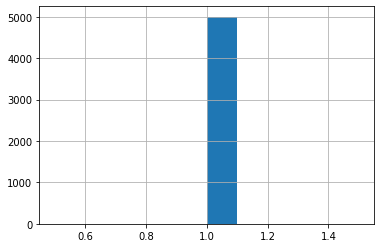

In [47]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean       65.548956
std         0.320073
min        64.420494
25%        65.329932
50%        65.543878
75%        65.757129
max        66.977608
dtype: float64


<AxesSubplot:>

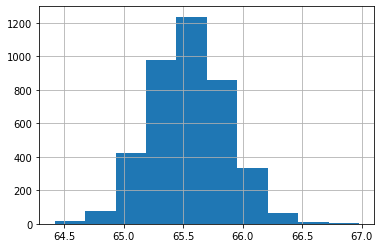

In [48]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

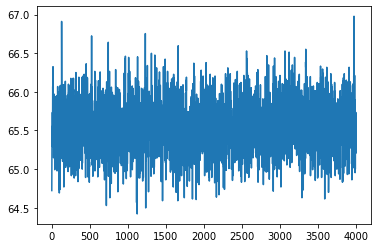

In [49]:
errors.plot()

Error metrics
count    4000.000000
mean       56.095643
std         2.852690
min        44.530888
25%        54.101756
50%        56.044625
75%        57.939624
max        67.786429
dtype: float64


<AxesSubplot:>

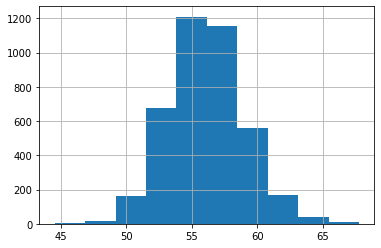

In [50]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
E_errors = pd.Series(E_errors)
print("Error metrics")
print(E_errors.describe())
E_errors.hist()

<AxesSubplot:>

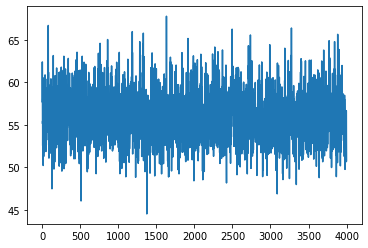

In [51]:
E_errors.plot()

In [67]:
# Binder loss function
# Sum for i < j -> 1 error for each pair that is equal in one and different in the other

def binder_loss(Z_sample, Z_true):
    # Input: Z_sample, Z_true matrices -> We only need the cluster indexes
    # Output: err scalar -> Sum of errors
    if Z_sample.shape != Z_true.shape:
        raise Exception('Error: Z matrices of different shape')
    # Idea: Turn matrices into single row to check all pairs more easily
    # First element checks all next elements
    # Get all possible pairs without repeating
    sample = Z_sample.flatten()
    true = Z_true.flatten()
    err = 0
    for i in range(len(sample)):  # Take the index of the first element of the pair
        for j in range(len(sample)-i-1):  # Index of the second element (taken from i onwards)
            # See only equals -> absolute of the difference
            # Eq + Eq -> abs(1-1) = 0 no error
            # Eq + Diff or Diff + Eq -> abs(1-0) = abs(0-1) = 1 error
            # Dif + Diff -> abs(0-0) = 0 no error
            equal_sample = int(sample[i]==sample[i+j+1])  # Fixed bug: Had i, j instead of i, j+i+1
            equal_true = int(true[i]==true[i+j+1])
            err += abs(equal_sample - equal_true)
            #print('Checked couple: '+str(i)+' with '+str(i+j+1))
    return err

In [68]:
Z_sample.flatten().size

960

In [69]:
%%time
# Testing
binder_loss(Z_sample, test_data.Z)  # Note that all possible pairs are 460320, so this is around 50%

Checked couple: 0 with 1
Checked couple: 0 with 2
Checked couple: 0 with 3
Checked couple: 0 with 4
Checked couple: 0 with 5
Checked couple: 0 with 6
Checked couple: 0 with 7
Checked couple: 0 with 8
Checked couple: 0 with 9
Checked couple: 0 with 10
Checked couple: 0 with 11
Checked couple: 0 with 12
Checked couple: 0 with 13
Checked couple: 0 with 14
Checked couple: 0 with 15
Checked couple: 0 with 16
Checked couple: 0 with 17
Checked couple: 0 with 18
Checked couple: 0 with 19
Checked couple: 0 with 20
Checked couple: 0 with 21
Checked couple: 0 with 22
Checked couple: 0 with 23
Checked couple: 0 with 24
Checked couple: 0 with 25
Checked couple: 0 with 26
Checked couple: 0 with 27
Checked couple: 0 with 28
Checked couple: 0 with 29
Checked couple: 0 with 30
Checked couple: 0 with 31
Checked couple: 0 with 32
Checked couple: 0 with 33
Checked couple: 0 with 34
Checked couple: 0 with 35
Checked couple: 0 with 36
Checked couple: 0 with 37
Checked couple: 0 with 38
Checked couple: 0 wit

Checked couple: 0 with 615
Checked couple: 0 with 616
Checked couple: 0 with 617
Checked couple: 0 with 618
Checked couple: 0 with 619
Checked couple: 0 with 620
Checked couple: 0 with 621
Checked couple: 0 with 622
Checked couple: 0 with 623
Checked couple: 0 with 624
Checked couple: 0 with 625
Checked couple: 0 with 626
Checked couple: 0 with 627
Checked couple: 0 with 628
Checked couple: 0 with 629
Checked couple: 0 with 630
Checked couple: 0 with 631
Checked couple: 0 with 632
Checked couple: 0 with 633
Checked couple: 0 with 634
Checked couple: 0 with 635
Checked couple: 0 with 636
Checked couple: 0 with 637
Checked couple: 0 with 638
Checked couple: 0 with 639
Checked couple: 0 with 640
Checked couple: 0 with 641
Checked couple: 0 with 642
Checked couple: 0 with 643
Checked couple: 0 with 644
Checked couple: 0 with 645
Checked couple: 0 with 646
Checked couple: 0 with 647
Checked couple: 0 with 648
Checked couple: 0 with 649
Checked couple: 0 with 650
Checked couple: 0 with 651
C

Checked couple: 0 with 957
Checked couple: 0 with 958
Checked couple: 0 with 959
Checked couple: 1 with 2
Checked couple: 1 with 3
Checked couple: 1 with 4
Checked couple: 1 with 5
Checked couple: 1 with 6
Checked couple: 1 with 7
Checked couple: 1 with 8
Checked couple: 1 with 9
Checked couple: 1 with 10
Checked couple: 1 with 11
Checked couple: 1 with 12
Checked couple: 1 with 13
Checked couple: 1 with 14
Checked couple: 1 with 15
Checked couple: 1 with 16
Checked couple: 1 with 17
Checked couple: 1 with 18
Checked couple: 1 with 19
Checked couple: 1 with 20
Checked couple: 1 with 21
Checked couple: 1 with 22
Checked couple: 1 with 23
Checked couple: 1 with 24
Checked couple: 1 with 25
Checked couple: 1 with 26
Checked couple: 1 with 27
Checked couple: 1 with 28
Checked couple: 1 with 29
Checked couple: 1 with 30
Checked couple: 1 with 31
Checked couple: 1 with 32
Checked couple: 1 with 33
Checked couple: 1 with 34
Checked couple: 1 with 35
Checked couple: 1 with 36
Checked couple: 1

Checked couple: 1 with 498
Checked couple: 1 with 499
Checked couple: 1 with 500
Checked couple: 1 with 501
Checked couple: 1 with 502
Checked couple: 1 with 503
Checked couple: 1 with 504
Checked couple: 1 with 505
Checked couple: 1 with 506
Checked couple: 1 with 507
Checked couple: 1 with 508
Checked couple: 1 with 509
Checked couple: 1 with 510
Checked couple: 1 with 511
Checked couple: 1 with 512
Checked couple: 1 with 513
Checked couple: 1 with 514
Checked couple: 1 with 515
Checked couple: 1 with 516
Checked couple: 1 with 517
Checked couple: 1 with 518
Checked couple: 1 with 519
Checked couple: 1 with 520
Checked couple: 1 with 521
Checked couple: 1 with 522
Checked couple: 1 with 523
Checked couple: 1 with 524
Checked couple: 1 with 525
Checked couple: 1 with 526
Checked couple: 1 with 527
Checked couple: 1 with 528
Checked couple: 1 with 529
Checked couple: 1 with 530
Checked couple: 1 with 531
Checked couple: 1 with 532
Checked couple: 1 with 533
Checked couple: 1 with 534
C

Checked couple: 2 with 41
Checked couple: 2 with 42
Checked couple: 2 with 43
Checked couple: 2 with 44
Checked couple: 2 with 45
Checked couple: 2 with 46
Checked couple: 2 with 47
Checked couple: 2 with 48
Checked couple: 2 with 49
Checked couple: 2 with 50
Checked couple: 2 with 51
Checked couple: 2 with 52
Checked couple: 2 with 53
Checked couple: 2 with 54
Checked couple: 2 with 55
Checked couple: 2 with 56
Checked couple: 2 with 57
Checked couple: 2 with 58
Checked couple: 2 with 59
Checked couple: 2 with 60
Checked couple: 2 with 61
Checked couple: 2 with 62
Checked couple: 2 with 63
Checked couple: 2 with 64
Checked couple: 2 with 65
Checked couple: 2 with 66
Checked couple: 2 with 67
Checked couple: 2 with 68
Checked couple: 2 with 69
Checked couple: 2 with 70
Checked couple: 2 with 71
Checked couple: 2 with 72
Checked couple: 2 with 73
Checked couple: 2 with 74
Checked couple: 2 with 75
Checked couple: 2 with 76
Checked couple: 2 with 77
Checked couple: 2 with 78
Checked coup

Checked couple: 2 with 540
Checked couple: 2 with 541
Checked couple: 2 with 542
Checked couple: 2 with 543
Checked couple: 2 with 544
Checked couple: 2 with 545
Checked couple: 2 with 546
Checked couple: 2 with 547
Checked couple: 2 with 548
Checked couple: 2 with 549
Checked couple: 2 with 550
Checked couple: 2 with 551
Checked couple: 2 with 552
Checked couple: 2 with 553
Checked couple: 2 with 554
Checked couple: 2 with 555
Checked couple: 2 with 556
Checked couple: 2 with 557
Checked couple: 2 with 558
Checked couple: 2 with 559
Checked couple: 2 with 560
Checked couple: 2 with 561
Checked couple: 2 with 562
Checked couple: 2 with 563
Checked couple: 2 with 564
Checked couple: 2 with 565
Checked couple: 2 with 566
Checked couple: 2 with 567
Checked couple: 2 with 568
Checked couple: 2 with 569
Checked couple: 2 with 570
Checked couple: 2 with 571
Checked couple: 2 with 572
Checked couple: 2 with 573
Checked couple: 2 with 574
Checked couple: 2 with 575
Checked couple: 2 with 576
C

Checked couple: 3 with 84
Checked couple: 3 with 85
Checked couple: 3 with 86
Checked couple: 3 with 87
Checked couple: 3 with 88
Checked couple: 3 with 89
Checked couple: 3 with 90
Checked couple: 3 with 91
Checked couple: 3 with 92
Checked couple: 3 with 93
Checked couple: 3 with 94
Checked couple: 3 with 95
Checked couple: 3 with 96
Checked couple: 3 with 97
Checked couple: 3 with 98
Checked couple: 3 with 99
Checked couple: 3 with 100
Checked couple: 3 with 101
Checked couple: 3 with 102
Checked couple: 3 with 103
Checked couple: 3 with 104
Checked couple: 3 with 105
Checked couple: 3 with 106
Checked couple: 3 with 107
Checked couple: 3 with 108
Checked couple: 3 with 109
Checked couple: 3 with 110
Checked couple: 3 with 111
Checked couple: 3 with 112
Checked couple: 3 with 113
Checked couple: 3 with 114
Checked couple: 3 with 115
Checked couple: 3 with 116
Checked couple: 3 with 117
Checked couple: 3 with 118
Checked couple: 3 with 119
Checked couple: 3 with 120
Checked couple: 3

Checked couple: 3 with 583
Checked couple: 3 with 584
Checked couple: 3 with 585
Checked couple: 3 with 586
Checked couple: 3 with 587
Checked couple: 3 with 588
Checked couple: 3 with 589
Checked couple: 3 with 590
Checked couple: 3 with 591
Checked couple: 3 with 592
Checked couple: 3 with 593
Checked couple: 3 with 594
Checked couple: 3 with 595
Checked couple: 3 with 596
Checked couple: 3 with 597
Checked couple: 3 with 598
Checked couple: 3 with 599
Checked couple: 3 with 600
Checked couple: 3 with 601
Checked couple: 3 with 602
Checked couple: 3 with 603
Checked couple: 3 with 604
Checked couple: 3 with 605
Checked couple: 3 with 606
Checked couple: 3 with 607
Checked couple: 3 with 608
Checked couple: 3 with 609
Checked couple: 3 with 610
Checked couple: 3 with 611
Checked couple: 3 with 612
Checked couple: 3 with 613
Checked couple: 3 with 614
Checked couple: 3 with 615
Checked couple: 3 with 616
Checked couple: 3 with 617
Checked couple: 3 with 618
Checked couple: 3 with 619
C

Checked couple: 4 with 128
Checked couple: 4 with 129
Checked couple: 4 with 130
Checked couple: 4 with 131
Checked couple: 4 with 132
Checked couple: 4 with 133
Checked couple: 4 with 134
Checked couple: 4 with 135
Checked couple: 4 with 136
Checked couple: 4 with 137
Checked couple: 4 with 138
Checked couple: 4 with 139
Checked couple: 4 with 140
Checked couple: 4 with 141
Checked couple: 4 with 142
Checked couple: 4 with 143
Checked couple: 4 with 144
Checked couple: 4 with 145
Checked couple: 4 with 146
Checked couple: 4 with 147
Checked couple: 4 with 148
Checked couple: 4 with 149
Checked couple: 4 with 150
Checked couple: 4 with 151
Checked couple: 4 with 152
Checked couple: 4 with 153
Checked couple: 4 with 154
Checked couple: 4 with 155
Checked couple: 4 with 156
Checked couple: 4 with 157
Checked couple: 4 with 158
Checked couple: 4 with 159
Checked couple: 4 with 160
Checked couple: 4 with 161
Checked couple: 4 with 162
Checked couple: 4 with 163
Checked couple: 4 with 164
C

Checked couple: 4 with 627
Checked couple: 4 with 628
Checked couple: 4 with 629
Checked couple: 4 with 630
Checked couple: 4 with 631
Checked couple: 4 with 632
Checked couple: 4 with 633
Checked couple: 4 with 634
Checked couple: 4 with 635
Checked couple: 4 with 636
Checked couple: 4 with 637
Checked couple: 4 with 638
Checked couple: 4 with 639
Checked couple: 4 with 640
Checked couple: 4 with 641
Checked couple: 4 with 642
Checked couple: 4 with 643
Checked couple: 4 with 644
Checked couple: 4 with 645
Checked couple: 4 with 646
Checked couple: 4 with 647
Checked couple: 4 with 648
Checked couple: 4 with 649
Checked couple: 4 with 650
Checked couple: 4 with 651
Checked couple: 4 with 652
Checked couple: 4 with 653
Checked couple: 4 with 654
Checked couple: 4 with 655
Checked couple: 4 with 656
Checked couple: 4 with 657
Checked couple: 4 with 658
Checked couple: 4 with 659
Checked couple: 4 with 660
Checked couple: 4 with 661
Checked couple: 4 with 662
Checked couple: 4 with 663
C

Checked couple: 5 with 173
Checked couple: 5 with 174
Checked couple: 5 with 175
Checked couple: 5 with 176
Checked couple: 5 with 177
Checked couple: 5 with 178
Checked couple: 5 with 179
Checked couple: 5 with 180
Checked couple: 5 with 181
Checked couple: 5 with 182
Checked couple: 5 with 183
Checked couple: 5 with 184
Checked couple: 5 with 185
Checked couple: 5 with 186
Checked couple: 5 with 187
Checked couple: 5 with 188
Checked couple: 5 with 189
Checked couple: 5 with 190
Checked couple: 5 with 191
Checked couple: 5 with 192
Checked couple: 5 with 193
Checked couple: 5 with 194
Checked couple: 5 with 195
Checked couple: 5 with 196
Checked couple: 5 with 197
Checked couple: 5 with 198
Checked couple: 5 with 199
Checked couple: 5 with 200
Checked couple: 5 with 201
Checked couple: 5 with 202
Checked couple: 5 with 203
Checked couple: 5 with 204
Checked couple: 5 with 205
Checked couple: 5 with 206
Checked couple: 5 with 207
Checked couple: 5 with 208
Checked couple: 5 with 209
C

Checked couple: 5 with 672
Checked couple: 5 with 673
Checked couple: 5 with 674
Checked couple: 5 with 675
Checked couple: 5 with 676
Checked couple: 5 with 677
Checked couple: 5 with 678
Checked couple: 5 with 679
Checked couple: 5 with 680
Checked couple: 5 with 681
Checked couple: 5 with 682
Checked couple: 5 with 683
Checked couple: 5 with 684
Checked couple: 5 with 685
Checked couple: 5 with 686
Checked couple: 5 with 687
Checked couple: 5 with 688
Checked couple: 5 with 689
Checked couple: 5 with 690
Checked couple: 5 with 691
Checked couple: 5 with 692
Checked couple: 5 with 693
Checked couple: 5 with 694
Checked couple: 5 with 695
Checked couple: 5 with 696
Checked couple: 5 with 697
Checked couple: 5 with 698
Checked couple: 5 with 699
Checked couple: 5 with 700
Checked couple: 5 with 701
Checked couple: 5 with 702
Checked couple: 5 with 703
Checked couple: 5 with 704
Checked couple: 5 with 705
Checked couple: 5 with 706
Checked couple: 5 with 707
Checked couple: 5 with 708
C

Checked couple: 6 with 219
Checked couple: 6 with 220
Checked couple: 6 with 221
Checked couple: 6 with 222
Checked couple: 6 with 223
Checked couple: 6 with 224
Checked couple: 6 with 225
Checked couple: 6 with 226
Checked couple: 6 with 227
Checked couple: 6 with 228
Checked couple: 6 with 229
Checked couple: 6 with 230
Checked couple: 6 with 231
Checked couple: 6 with 232
Checked couple: 6 with 233
Checked couple: 6 with 234
Checked couple: 6 with 235
Checked couple: 6 with 236
Checked couple: 6 with 237
Checked couple: 6 with 238
Checked couple: 6 with 239
Checked couple: 6 with 240
Checked couple: 6 with 241
Checked couple: 6 with 242
Checked couple: 6 with 243
Checked couple: 6 with 244
Checked couple: 6 with 245
Checked couple: 6 with 246
Checked couple: 6 with 247
Checked couple: 6 with 248
Checked couple: 6 with 249
Checked couple: 6 with 250
Checked couple: 6 with 251
Checked couple: 6 with 252
Checked couple: 6 with 253
Checked couple: 6 with 254
Checked couple: 6 with 255
C

Checked couple: 6 with 718
Checked couple: 6 with 719
Checked couple: 6 with 720
Checked couple: 6 with 721
Checked couple: 6 with 722
Checked couple: 6 with 723
Checked couple: 6 with 724
Checked couple: 6 with 725
Checked couple: 6 with 726
Checked couple: 6 with 727
Checked couple: 6 with 728
Checked couple: 6 with 729
Checked couple: 6 with 730
Checked couple: 6 with 731
Checked couple: 6 with 732
Checked couple: 6 with 733
Checked couple: 6 with 734
Checked couple: 6 with 735
Checked couple: 6 with 736
Checked couple: 6 with 737
Checked couple: 6 with 738
Checked couple: 6 with 739
Checked couple: 6 with 740
Checked couple: 6 with 741
Checked couple: 6 with 742
Checked couple: 6 with 743
Checked couple: 6 with 744
Checked couple: 6 with 745
Checked couple: 6 with 746
Checked couple: 6 with 747
Checked couple: 6 with 748
Checked couple: 6 with 749
Checked couple: 6 with 750
Checked couple: 6 with 751
Checked couple: 6 with 752
Checked couple: 6 with 753
Checked couple: 6 with 754
C

Checked couple: 7 with 266
Checked couple: 7 with 267
Checked couple: 7 with 268
Checked couple: 7 with 269
Checked couple: 7 with 270
Checked couple: 7 with 271
Checked couple: 7 with 272
Checked couple: 7 with 273
Checked couple: 7 with 274
Checked couple: 7 with 275
Checked couple: 7 with 276
Checked couple: 7 with 277
Checked couple: 7 with 278
Checked couple: 7 with 279
Checked couple: 7 with 280
Checked couple: 7 with 281
Checked couple: 7 with 282
Checked couple: 7 with 283
Checked couple: 7 with 284
Checked couple: 7 with 285
Checked couple: 7 with 286
Checked couple: 7 with 287
Checked couple: 7 with 288
Checked couple: 7 with 289
Checked couple: 7 with 290
Checked couple: 7 with 291
Checked couple: 7 with 292
Checked couple: 7 with 293
Checked couple: 7 with 294
Checked couple: 7 with 295
Checked couple: 7 with 296
Checked couple: 7 with 297
Checked couple: 7 with 298
Checked couple: 7 with 299
Checked couple: 7 with 300
Checked couple: 7 with 301
Checked couple: 7 with 302
C

Checked couple: 7 with 765
Checked couple: 7 with 766
Checked couple: 7 with 767
Checked couple: 7 with 768
Checked couple: 7 with 769
Checked couple: 7 with 770
Checked couple: 7 with 771
Checked couple: 7 with 772
Checked couple: 7 with 773
Checked couple: 7 with 774
Checked couple: 7 with 775
Checked couple: 7 with 776
Checked couple: 7 with 777
Checked couple: 7 with 778
Checked couple: 7 with 779
Checked couple: 7 with 780
Checked couple: 7 with 781
Checked couple: 7 with 782
Checked couple: 7 with 783
Checked couple: 7 with 784
Checked couple: 7 with 785
Checked couple: 7 with 786
Checked couple: 7 with 787
Checked couple: 7 with 788
Checked couple: 7 with 789
Checked couple: 7 with 790
Checked couple: 7 with 791
Checked couple: 7 with 792
Checked couple: 7 with 793
Checked couple: 7 with 794
Checked couple: 7 with 795
Checked couple: 7 with 796
Checked couple: 7 with 797
Checked couple: 7 with 798
Checked couple: 7 with 799
Checked couple: 7 with 800
Checked couple: 7 with 801
C

Checked couple: 8 with 314
Checked couple: 8 with 315
Checked couple: 8 with 316
Checked couple: 8 with 317
Checked couple: 8 with 318
Checked couple: 8 with 319
Checked couple: 8 with 320
Checked couple: 8 with 321
Checked couple: 8 with 322
Checked couple: 8 with 323
Checked couple: 8 with 324
Checked couple: 8 with 325
Checked couple: 8 with 326
Checked couple: 8 with 327
Checked couple: 8 with 328
Checked couple: 8 with 329
Checked couple: 8 with 330
Checked couple: 8 with 331
Checked couple: 8 with 332
Checked couple: 8 with 333
Checked couple: 8 with 334
Checked couple: 8 with 335
Checked couple: 8 with 336
Checked couple: 8 with 337
Checked couple: 8 with 338
Checked couple: 8 with 339
Checked couple: 8 with 340
Checked couple: 8 with 341
Checked couple: 8 with 342
Checked couple: 8 with 343
Checked couple: 8 with 344
Checked couple: 8 with 345
Checked couple: 8 with 346
Checked couple: 8 with 347
Checked couple: 8 with 348
Checked couple: 8 with 349
Checked couple: 8 with 350
C

Checked couple: 8 with 813
Checked couple: 8 with 814
Checked couple: 8 with 815
Checked couple: 8 with 816
Checked couple: 8 with 817
Checked couple: 8 with 818
Checked couple: 8 with 819
Checked couple: 8 with 820
Checked couple: 8 with 821
Checked couple: 8 with 822
Checked couple: 8 with 823
Checked couple: 8 with 824
Checked couple: 8 with 825
Checked couple: 8 with 826
Checked couple: 8 with 827
Checked couple: 8 with 828
Checked couple: 8 with 829
Checked couple: 8 with 830
Checked couple: 8 with 831
Checked couple: 8 with 832
Checked couple: 8 with 833
Checked couple: 8 with 834
Checked couple: 8 with 835
Checked couple: 8 with 836
Checked couple: 8 with 837
Checked couple: 8 with 838
Checked couple: 8 with 839
Checked couple: 8 with 840
Checked couple: 8 with 841
Checked couple: 8 with 842
Checked couple: 8 with 843
Checked couple: 8 with 844
Checked couple: 8 with 845
Checked couple: 8 with 846
Checked couple: 8 with 847
Checked couple: 8 with 848
Checked couple: 8 with 849
C

Checked couple: 9 with 363
Checked couple: 9 with 364
Checked couple: 9 with 365
Checked couple: 9 with 366
Checked couple: 9 with 367
Checked couple: 9 with 368
Checked couple: 9 with 369
Checked couple: 9 with 370
Checked couple: 9 with 371
Checked couple: 9 with 372
Checked couple: 9 with 373
Checked couple: 9 with 374
Checked couple: 9 with 375
Checked couple: 9 with 376
Checked couple: 9 with 377
Checked couple: 9 with 378
Checked couple: 9 with 379
Checked couple: 9 with 380
Checked couple: 9 with 381
Checked couple: 9 with 382
Checked couple: 9 with 383
Checked couple: 9 with 384
Checked couple: 9 with 385
Checked couple: 9 with 386
Checked couple: 9 with 387
Checked couple: 9 with 388
Checked couple: 9 with 389
Checked couple: 9 with 390
Checked couple: 9 with 391
Checked couple: 9 with 392
Checked couple: 9 with 393
Checked couple: 9 with 394
Checked couple: 9 with 395
Checked couple: 9 with 396
Checked couple: 9 with 397
Checked couple: 9 with 398
Checked couple: 9 with 399
C

Checked couple: 9 with 862
Checked couple: 9 with 863
Checked couple: 9 with 864
Checked couple: 9 with 865
Checked couple: 9 with 866
Checked couple: 9 with 867
Checked couple: 9 with 868
Checked couple: 9 with 869
Checked couple: 9 with 870
Checked couple: 9 with 871
Checked couple: 9 with 872
Checked couple: 9 with 873
Checked couple: 9 with 874
Checked couple: 9 with 875
Checked couple: 9 with 876
Checked couple: 9 with 877
Checked couple: 9 with 878
Checked couple: 9 with 879
Checked couple: 9 with 880
Checked couple: 9 with 881
Checked couple: 9 with 882
Checked couple: 9 with 883
Checked couple: 9 with 884
Checked couple: 9 with 885
Checked couple: 9 with 886
Checked couple: 9 with 887
Checked couple: 9 with 888
Checked couple: 9 with 889
Checked couple: 9 with 890
Checked couple: 9 with 891
Checked couple: 9 with 892
Checked couple: 9 with 893
Checked couple: 9 with 894
Checked couple: 9 with 895
Checked couple: 9 with 896
Checked couple: 9 with 897
Checked couple: 9 with 898
C

Checked couple: 10 with 411
Checked couple: 10 with 412
Checked couple: 10 with 413
Checked couple: 10 with 414
Checked couple: 10 with 415
Checked couple: 10 with 416
Checked couple: 10 with 417
Checked couple: 10 with 418
Checked couple: 10 with 419
Checked couple: 10 with 420
Checked couple: 10 with 421
Checked couple: 10 with 422
Checked couple: 10 with 423
Checked couple: 10 with 424
Checked couple: 10 with 425
Checked couple: 10 with 426
Checked couple: 10 with 427
Checked couple: 10 with 428
Checked couple: 10 with 429
Checked couple: 10 with 430
Checked couple: 10 with 431
Checked couple: 10 with 432
Checked couple: 10 with 433
Checked couple: 10 with 434
Checked couple: 10 with 435
Checked couple: 10 with 436
Checked couple: 10 with 437
Checked couple: 10 with 438
Checked couple: 10 with 439
Checked couple: 10 with 440
Checked couple: 10 with 441
Checked couple: 10 with 442
Checked couple: 10 with 443
Checked couple: 10 with 444
Checked couple: 10 with 445
Checked couple: 10 w

Checked couple: 10 with 912
Checked couple: 10 with 913
Checked couple: 10 with 914
Checked couple: 10 with 915
Checked couple: 10 with 916
Checked couple: 10 with 917
Checked couple: 10 with 918
Checked couple: 10 with 919
Checked couple: 10 with 920
Checked couple: 10 with 921
Checked couple: 10 with 922
Checked couple: 10 with 923
Checked couple: 10 with 924
Checked couple: 10 with 925
Checked couple: 10 with 926
Checked couple: 10 with 927
Checked couple: 10 with 928
Checked couple: 10 with 929
Checked couple: 10 with 930
Checked couple: 10 with 931
Checked couple: 10 with 932
Checked couple: 10 with 933
Checked couple: 10 with 934
Checked couple: 10 with 935
Checked couple: 10 with 936
Checked couple: 10 with 937
Checked couple: 10 with 938
Checked couple: 10 with 939
Checked couple: 10 with 940
Checked couple: 10 with 941
Checked couple: 10 with 942
Checked couple: 10 with 943
Checked couple: 10 with 944
Checked couple: 10 with 945
Checked couple: 10 with 946
Checked couple: 10 w

Checked couple: 11 with 285
Checked couple: 11 with 286
Checked couple: 11 with 287
Checked couple: 11 with 288
Checked couple: 11 with 289
Checked couple: 11 with 290
Checked couple: 11 with 291
Checked couple: 11 with 292
Checked couple: 11 with 293
Checked couple: 11 with 294
Checked couple: 11 with 295
Checked couple: 11 with 296
Checked couple: 11 with 297
Checked couple: 11 with 298
Checked couple: 11 with 299
Checked couple: 11 with 300
Checked couple: 11 with 301
Checked couple: 11 with 302
Checked couple: 11 with 303
Checked couple: 11 with 304
Checked couple: 11 with 305
Checked couple: 11 with 306
Checked couple: 11 with 307
Checked couple: 11 with 308
Checked couple: 11 with 309
Checked couple: 11 with 310
Checked couple: 11 with 311
Checked couple: 11 with 312
Checked couple: 11 with 313
Checked couple: 11 with 314
Checked couple: 11 with 315
Checked couple: 11 with 316
Checked couple: 11 with 317
Checked couple: 11 with 318
Checked couple: 11 with 319
Checked couple: 11 w

Checked couple: 12 with 15
Checked couple: 12 with 16
Checked couple: 12 with 17
Checked couple: 12 with 18
Checked couple: 12 with 19
Checked couple: 12 with 20
Checked couple: 12 with 21
Checked couple: 12 with 22
Checked couple: 12 with 23
Checked couple: 12 with 24
Checked couple: 12 with 25
Checked couple: 12 with 26
Checked couple: 12 with 27
Checked couple: 12 with 28
Checked couple: 12 with 29
Checked couple: 12 with 30
Checked couple: 12 with 31
Checked couple: 12 with 32
Checked couple: 12 with 33
Checked couple: 12 with 34
Checked couple: 12 with 35
Checked couple: 12 with 36
Checked couple: 12 with 37
Checked couple: 12 with 38
Checked couple: 12 with 39
Checked couple: 12 with 40
Checked couple: 12 with 41
Checked couple: 12 with 42
Checked couple: 12 with 43
Checked couple: 12 with 44
Checked couple: 12 with 45
Checked couple: 12 with 46
Checked couple: 12 with 47
Checked couple: 12 with 48
Checked couple: 12 with 49
Checked couple: 12 with 50
Checked couple: 12 with 51
C

Checked couple: 12 with 515
Checked couple: 12 with 516
Checked couple: 12 with 517
Checked couple: 12 with 518
Checked couple: 12 with 519
Checked couple: 12 with 520
Checked couple: 12 with 521
Checked couple: 12 with 522
Checked couple: 12 with 523
Checked couple: 12 with 524
Checked couple: 12 with 525
Checked couple: 12 with 526
Checked couple: 12 with 527
Checked couple: 12 with 528
Checked couple: 12 with 529
Checked couple: 12 with 530
Checked couple: 12 with 531
Checked couple: 12 with 532
Checked couple: 12 with 533
Checked couple: 12 with 534
Checked couple: 12 with 535
Checked couple: 12 with 536
Checked couple: 12 with 537
Checked couple: 12 with 538
Checked couple: 12 with 539
Checked couple: 12 with 540
Checked couple: 12 with 541
Checked couple: 12 with 542
Checked couple: 12 with 543
Checked couple: 12 with 544
Checked couple: 12 with 545
Checked couple: 12 with 546
Checked couple: 12 with 547
Checked couple: 12 with 548
Checked couple: 12 with 549
Checked couple: 12 w

Checked couple: 13 with 568
Checked couple: 13 with 569
Checked couple: 13 with 570
Checked couple: 13 with 571
Checked couple: 13 with 572
Checked couple: 13 with 573
Checked couple: 13 with 574
Checked couple: 13 with 575
Checked couple: 13 with 576
Checked couple: 13 with 577
Checked couple: 13 with 578
Checked couple: 13 with 579
Checked couple: 13 with 580
Checked couple: 13 with 581
Checked couple: 13 with 582
Checked couple: 13 with 583
Checked couple: 13 with 584
Checked couple: 13 with 585
Checked couple: 13 with 586
Checked couple: 13 with 587
Checked couple: 13 with 588
Checked couple: 13 with 589
Checked couple: 13 with 590
Checked couple: 13 with 591
Checked couple: 13 with 592
Checked couple: 13 with 593
Checked couple: 13 with 594
Checked couple: 13 with 595
Checked couple: 13 with 596
Checked couple: 13 with 597
Checked couple: 13 with 598
Checked couple: 13 with 599
Checked couple: 13 with 600
Checked couple: 13 with 601
Checked couple: 13 with 602
Checked couple: 13 w

Checked couple: 13 with 908
Checked couple: 13 with 909
Checked couple: 13 with 910
Checked couple: 13 with 911
Checked couple: 13 with 912
Checked couple: 13 with 913
Checked couple: 13 with 914
Checked couple: 13 with 915
Checked couple: 13 with 916
Checked couple: 13 with 917
Checked couple: 13 with 918
Checked couple: 13 with 919
Checked couple: 13 with 920
Checked couple: 13 with 921
Checked couple: 13 with 922
Checked couple: 13 with 923
Checked couple: 13 with 924
Checked couple: 13 with 925
Checked couple: 13 with 926
Checked couple: 13 with 927
Checked couple: 13 with 928
Checked couple: 13 with 929
Checked couple: 13 with 930
Checked couple: 13 with 931
Checked couple: 13 with 932
Checked couple: 13 with 933
Checked couple: 13 with 934
Checked couple: 13 with 935
Checked couple: 13 with 936
Checked couple: 13 with 937
Checked couple: 13 with 938
Checked couple: 13 with 939
Checked couple: 13 with 940
Checked couple: 13 with 941
Checked couple: 13 with 942
Checked couple: 13 w

Checked couple: 14 with 689
Checked couple: 14 with 690
Checked couple: 14 with 691
Checked couple: 14 with 692
Checked couple: 14 with 693
Checked couple: 14 with 694
Checked couple: 14 with 695
Checked couple: 14 with 696
Checked couple: 14 with 697
Checked couple: 14 with 698
Checked couple: 14 with 699
Checked couple: 14 with 700
Checked couple: 14 with 701
Checked couple: 14 with 702
Checked couple: 14 with 703
Checked couple: 14 with 704
Checked couple: 14 with 705
Checked couple: 14 with 706
Checked couple: 14 with 707
Checked couple: 14 with 708
Checked couple: 14 with 709
Checked couple: 14 with 710
Checked couple: 14 with 711
Checked couple: 14 with 712
Checked couple: 14 with 713
Checked couple: 14 with 714
Checked couple: 14 with 715
Checked couple: 14 with 716
Checked couple: 14 with 717
Checked couple: 14 with 718
Checked couple: 14 with 719
Checked couple: 14 with 720
Checked couple: 14 with 721
Checked couple: 14 with 722
Checked couple: 14 with 723
Checked couple: 14 w

Checked couple: 15 with 343
Checked couple: 15 with 344
Checked couple: 15 with 345
Checked couple: 15 with 346
Checked couple: 15 with 347
Checked couple: 15 with 348
Checked couple: 15 with 349
Checked couple: 15 with 350
Checked couple: 15 with 351
Checked couple: 15 with 352
Checked couple: 15 with 353
Checked couple: 15 with 354
Checked couple: 15 with 355
Checked couple: 15 with 356
Checked couple: 15 with 357
Checked couple: 15 with 358
Checked couple: 15 with 359
Checked couple: 15 with 360
Checked couple: 15 with 361
Checked couple: 15 with 362
Checked couple: 15 with 363
Checked couple: 15 with 364
Checked couple: 15 with 365
Checked couple: 15 with 366
Checked couple: 15 with 367
Checked couple: 15 with 368
Checked couple: 15 with 369
Checked couple: 15 with 370
Checked couple: 15 with 371
Checked couple: 15 with 372
Checked couple: 15 with 373
Checked couple: 15 with 374
Checked couple: 15 with 375
Checked couple: 15 with 376
Checked couple: 15 with 377
Checked couple: 15 w

Checked couple: 15 with 789
Checked couple: 15 with 790
Checked couple: 15 with 791
Checked couple: 15 with 792
Checked couple: 15 with 793
Checked couple: 15 with 794
Checked couple: 15 with 795
Checked couple: 15 with 796
Checked couple: 15 with 797
Checked couple: 15 with 798
Checked couple: 15 with 799
Checked couple: 15 with 800
Checked couple: 15 with 801
Checked couple: 15 with 802
Checked couple: 15 with 803
Checked couple: 15 with 804
Checked couple: 15 with 805
Checked couple: 15 with 806
Checked couple: 15 with 807
Checked couple: 15 with 808
Checked couple: 15 with 809
Checked couple: 15 with 810
Checked couple: 15 with 811
Checked couple: 15 with 812
Checked couple: 15 with 813
Checked couple: 15 with 814
Checked couple: 15 with 815
Checked couple: 15 with 816
Checked couple: 15 with 817
Checked couple: 15 with 818
Checked couple: 15 with 819
Checked couple: 15 with 820
Checked couple: 15 with 821
Checked couple: 15 with 822
Checked couple: 15 with 823
Checked couple: 15 w

Checked couple: 16 with 232
Checked couple: 16 with 233
Checked couple: 16 with 234
Checked couple: 16 with 235
Checked couple: 16 with 236
Checked couple: 16 with 237
Checked couple: 16 with 238
Checked couple: 16 with 239
Checked couple: 16 with 240
Checked couple: 16 with 241
Checked couple: 16 with 242
Checked couple: 16 with 243
Checked couple: 16 with 244
Checked couple: 16 with 245
Checked couple: 16 with 246
Checked couple: 16 with 247
Checked couple: 16 with 248
Checked couple: 16 with 249
Checked couple: 16 with 250
Checked couple: 16 with 251
Checked couple: 16 with 252
Checked couple: 16 with 253
Checked couple: 16 with 254
Checked couple: 16 with 255
Checked couple: 16 with 256
Checked couple: 16 with 257
Checked couple: 16 with 258
Checked couple: 16 with 259
Checked couple: 16 with 260
Checked couple: 16 with 261
Checked couple: 16 with 262
Checked couple: 16 with 263
Checked couple: 16 with 264
Checked couple: 16 with 265
Checked couple: 16 with 266
Checked couple: 16 w

Checked couple: 16 with 616
Checked couple: 16 with 617
Checked couple: 16 with 618
Checked couple: 16 with 619
Checked couple: 16 with 620
Checked couple: 16 with 621
Checked couple: 16 with 622
Checked couple: 16 with 623
Checked couple: 16 with 624
Checked couple: 16 with 625
Checked couple: 16 with 626
Checked couple: 16 with 627
Checked couple: 16 with 628
Checked couple: 16 with 629
Checked couple: 16 with 630
Checked couple: 16 with 631
Checked couple: 16 with 632
Checked couple: 16 with 633
Checked couple: 16 with 634
Checked couple: 16 with 635
Checked couple: 16 with 636
Checked couple: 16 with 637
Checked couple: 16 with 638
Checked couple: 16 with 639
Checked couple: 16 with 640
Checked couple: 16 with 641
Checked couple: 16 with 642
Checked couple: 16 with 643
Checked couple: 16 with 644
Checked couple: 16 with 645
Checked couple: 16 with 646
Checked couple: 16 with 647
Checked couple: 16 with 648
Checked couple: 16 with 649
Checked couple: 16 with 650
Checked couple: 16 w

Checked couple: 17 with 289
Checked couple: 17 with 290
Checked couple: 17 with 291
Checked couple: 17 with 292
Checked couple: 17 with 293
Checked couple: 17 with 294
Checked couple: 17 with 295
Checked couple: 17 with 296
Checked couple: 17 with 297
Checked couple: 17 with 298
Checked couple: 17 with 299
Checked couple: 17 with 300
Checked couple: 17 with 301
Checked couple: 17 with 302
Checked couple: 17 with 303
Checked couple: 17 with 304
Checked couple: 17 with 305
Checked couple: 17 with 306
Checked couple: 17 with 307
Checked couple: 17 with 308
Checked couple: 17 with 309
Checked couple: 17 with 310
Checked couple: 17 with 311
Checked couple: 17 with 312
Checked couple: 17 with 313
Checked couple: 17 with 314
Checked couple: 17 with 315
Checked couple: 17 with 316
Checked couple: 17 with 317
Checked couple: 17 with 318
Checked couple: 17 with 319
Checked couple: 17 with 320
Checked couple: 17 with 321
Checked couple: 17 with 322
Checked couple: 17 with 323
Checked couple: 17 w

Checked couple: 17 with 674
Checked couple: 17 with 675
Checked couple: 17 with 676
Checked couple: 17 with 677
Checked couple: 17 with 678
Checked couple: 17 with 679
Checked couple: 17 with 680
Checked couple: 17 with 681
Checked couple: 17 with 682
Checked couple: 17 with 683
Checked couple: 17 with 684
Checked couple: 17 with 685
Checked couple: 17 with 686
Checked couple: 17 with 687
Checked couple: 17 with 688
Checked couple: 17 with 689
Checked couple: 17 with 690
Checked couple: 17 with 691
Checked couple: 17 with 692
Checked couple: 17 with 693
Checked couple: 17 with 694
Checked couple: 17 with 695
Checked couple: 17 with 696
Checked couple: 17 with 697
Checked couple: 17 with 698
Checked couple: 17 with 699
Checked couple: 17 with 700
Checked couple: 17 with 701
Checked couple: 17 with 702
Checked couple: 17 with 703
Checked couple: 17 with 704
Checked couple: 17 with 705
Checked couple: 17 with 706
Checked couple: 17 with 707
Checked couple: 17 with 708
Checked couple: 17 w

Checked couple: 18 with 347
Checked couple: 18 with 348
Checked couple: 18 with 349
Checked couple: 18 with 350
Checked couple: 18 with 351
Checked couple: 18 with 352
Checked couple: 18 with 353
Checked couple: 18 with 354
Checked couple: 18 with 355
Checked couple: 18 with 356
Checked couple: 18 with 357
Checked couple: 18 with 358
Checked couple: 18 with 359
Checked couple: 18 with 360
Checked couple: 18 with 361
Checked couple: 18 with 362
Checked couple: 18 with 363
Checked couple: 18 with 364
Checked couple: 18 with 365
Checked couple: 18 with 366
Checked couple: 18 with 367
Checked couple: 18 with 368
Checked couple: 18 with 369
Checked couple: 18 with 370
Checked couple: 18 with 371
Checked couple: 18 with 372
Checked couple: 18 with 373
Checked couple: 18 with 374
Checked couple: 18 with 375
Checked couple: 18 with 376
Checked couple: 18 with 377
Checked couple: 18 with 378
Checked couple: 18 with 379
Checked couple: 18 with 380
Checked couple: 18 with 381
Checked couple: 18 w

Checked couple: 18 with 846
Checked couple: 18 with 847
Checked couple: 18 with 848
Checked couple: 18 with 849
Checked couple: 18 with 850
Checked couple: 18 with 851
Checked couple: 18 with 852
Checked couple: 18 with 853
Checked couple: 18 with 854
Checked couple: 18 with 855
Checked couple: 18 with 856
Checked couple: 18 with 857
Checked couple: 18 with 858
Checked couple: 18 with 859
Checked couple: 18 with 860
Checked couple: 18 with 861
Checked couple: 18 with 862
Checked couple: 18 with 863
Checked couple: 18 with 864
Checked couple: 18 with 865
Checked couple: 18 with 866
Checked couple: 18 with 867
Checked couple: 18 with 868
Checked couple: 18 with 869
Checked couple: 18 with 870
Checked couple: 18 with 871
Checked couple: 18 with 872
Checked couple: 18 with 873
Checked couple: 18 with 874
Checked couple: 18 with 875
Checked couple: 18 with 876
Checked couple: 18 with 877
Checked couple: 18 with 878
Checked couple: 18 with 879
Checked couple: 18 with 880
Checked couple: 18 w

Checked couple: 19 with 406
Checked couple: 19 with 407
Checked couple: 19 with 408
Checked couple: 19 with 409
Checked couple: 19 with 410
Checked couple: 19 with 411
Checked couple: 19 with 412
Checked couple: 19 with 413
Checked couple: 19 with 414
Checked couple: 19 with 415
Checked couple: 19 with 416
Checked couple: 19 with 417
Checked couple: 19 with 418
Checked couple: 19 with 419
Checked couple: 19 with 420
Checked couple: 19 with 421
Checked couple: 19 with 422
Checked couple: 19 with 423
Checked couple: 19 with 424
Checked couple: 19 with 425
Checked couple: 19 with 426
Checked couple: 19 with 427
Checked couple: 19 with 428
Checked couple: 19 with 429
Checked couple: 19 with 430
Checked couple: 19 with 431
Checked couple: 19 with 432
Checked couple: 19 with 433
Checked couple: 19 with 434
Checked couple: 19 with 435
Checked couple: 19 with 436
Checked couple: 19 with 437
Checked couple: 19 with 438
Checked couple: 19 with 439
Checked couple: 19 with 440
Checked couple: 19 w

Checked couple: 19 with 881
Checked couple: 19 with 882
Checked couple: 19 with 883
Checked couple: 19 with 884
Checked couple: 19 with 885
Checked couple: 19 with 886
Checked couple: 19 with 887
Checked couple: 19 with 888
Checked couple: 19 with 889
Checked couple: 19 with 890
Checked couple: 19 with 891
Checked couple: 19 with 892
Checked couple: 19 with 893
Checked couple: 19 with 894
Checked couple: 19 with 895
Checked couple: 19 with 896
Checked couple: 19 with 897
Checked couple: 19 with 898
Checked couple: 19 with 899
Checked couple: 19 with 900
Checked couple: 19 with 901
Checked couple: 19 with 902
Checked couple: 19 with 903
Checked couple: 19 with 904
Checked couple: 19 with 905
Checked couple: 19 with 906
Checked couple: 19 with 907
Checked couple: 19 with 908
Checked couple: 19 with 909
Checked couple: 19 with 910
Checked couple: 19 with 911
Checked couple: 19 with 912
Checked couple: 19 with 913
Checked couple: 19 with 914
Checked couple: 19 with 915
Checked couple: 19 w

Checked couple: 21 with 46
Checked couple: 21 with 47
Checked couple: 21 with 48
Checked couple: 21 with 49
Checked couple: 21 with 50
Checked couple: 21 with 51
Checked couple: 21 with 52
Checked couple: 21 with 53
Checked couple: 21 with 54
Checked couple: 21 with 55
Checked couple: 21 with 56
Checked couple: 21 with 57
Checked couple: 21 with 58
Checked couple: 21 with 59
Checked couple: 21 with 60
Checked couple: 21 with 61
Checked couple: 21 with 62
Checked couple: 21 with 63
Checked couple: 21 with 64
Checked couple: 21 with 65
Checked couple: 21 with 66
Checked couple: 21 with 67
Checked couple: 21 with 68
Checked couple: 21 with 69
Checked couple: 21 with 70
Checked couple: 21 with 71
Checked couple: 21 with 72
Checked couple: 21 with 73
Checked couple: 21 with 74
Checked couple: 21 with 75
Checked couple: 21 with 76
Checked couple: 21 with 77
Checked couple: 21 with 78
Checked couple: 21 with 79
Checked couple: 21 with 80
Checked couple: 21 with 81
Checked couple: 21 with 82
C

Checked couple: 21 with 447
Checked couple: 21 with 448
Checked couple: 21 with 449
Checked couple: 21 with 450
Checked couple: 21 with 451
Checked couple: 21 with 452
Checked couple: 21 with 453
Checked couple: 21 with 454
Checked couple: 21 with 455
Checked couple: 21 with 456
Checked couple: 21 with 457
Checked couple: 21 with 458
Checked couple: 21 with 459
Checked couple: 21 with 460
Checked couple: 21 with 461
Checked couple: 21 with 462
Checked couple: 21 with 463
Checked couple: 21 with 464
Checked couple: 21 with 465
Checked couple: 21 with 466
Checked couple: 21 with 467
Checked couple: 21 with 468
Checked couple: 21 with 469
Checked couple: 21 with 470
Checked couple: 21 with 471
Checked couple: 21 with 472
Checked couple: 21 with 473
Checked couple: 21 with 474
Checked couple: 21 with 475
Checked couple: 21 with 476
Checked couple: 21 with 477
Checked couple: 21 with 478
Checked couple: 21 with 479
Checked couple: 21 with 480
Checked couple: 21 with 481
Checked couple: 21 w

Checked couple: 21 with 873
Checked couple: 21 with 874
Checked couple: 21 with 875
Checked couple: 21 with 876
Checked couple: 21 with 877
Checked couple: 21 with 878
Checked couple: 21 with 879
Checked couple: 21 with 880
Checked couple: 21 with 881
Checked couple: 21 with 882
Checked couple: 21 with 883
Checked couple: 21 with 884
Checked couple: 21 with 885
Checked couple: 21 with 886
Checked couple: 21 with 887
Checked couple: 21 with 888
Checked couple: 21 with 889
Checked couple: 21 with 890
Checked couple: 21 with 891
Checked couple: 21 with 892
Checked couple: 21 with 893
Checked couple: 21 with 894
Checked couple: 21 with 895
Checked couple: 21 with 896
Checked couple: 21 with 897
Checked couple: 21 with 898
Checked couple: 21 with 899
Checked couple: 21 with 900
Checked couple: 21 with 901
Checked couple: 21 with 902
Checked couple: 21 with 903
Checked couple: 21 with 904
Checked couple: 21 with 905
Checked couple: 21 with 906
Checked couple: 21 with 907
Checked couple: 21 w

Checked couple: 22 with 419
Checked couple: 22 with 420
Checked couple: 22 with 421
Checked couple: 22 with 422
Checked couple: 22 with 423
Checked couple: 22 with 424
Checked couple: 22 with 425
Checked couple: 22 with 426
Checked couple: 22 with 427
Checked couple: 22 with 428
Checked couple: 22 with 429
Checked couple: 22 with 430
Checked couple: 22 with 431
Checked couple: 22 with 432
Checked couple: 22 with 433
Checked couple: 22 with 434
Checked couple: 22 with 435
Checked couple: 22 with 436
Checked couple: 22 with 437
Checked couple: 22 with 438
Checked couple: 22 with 439
Checked couple: 22 with 440
Checked couple: 22 with 441
Checked couple: 22 with 442
Checked couple: 22 with 443
Checked couple: 22 with 444
Checked couple: 22 with 445
Checked couple: 22 with 446
Checked couple: 22 with 447
Checked couple: 22 with 448
Checked couple: 22 with 449
Checked couple: 22 with 450
Checked couple: 22 with 451
Checked couple: 22 with 452
Checked couple: 22 with 453
Checked couple: 22 w

Checked couple: 22 with 765
Checked couple: 22 with 766
Checked couple: 22 with 767
Checked couple: 22 with 768
Checked couple: 22 with 769
Checked couple: 22 with 770
Checked couple: 22 with 771
Checked couple: 22 with 772
Checked couple: 22 with 773
Checked couple: 22 with 774
Checked couple: 22 with 775
Checked couple: 22 with 776
Checked couple: 22 with 777
Checked couple: 22 with 778
Checked couple: 22 with 779
Checked couple: 22 with 780
Checked couple: 22 with 781
Checked couple: 22 with 782
Checked couple: 22 with 783
Checked couple: 22 with 784
Checked couple: 22 with 785
Checked couple: 22 with 786
Checked couple: 22 with 787
Checked couple: 22 with 788
Checked couple: 22 with 789
Checked couple: 22 with 790
Checked couple: 22 with 791
Checked couple: 22 with 792
Checked couple: 22 with 793
Checked couple: 22 with 794
Checked couple: 22 with 795
Checked couple: 22 with 796
Checked couple: 22 with 797
Checked couple: 22 with 798
Checked couple: 22 with 799
Checked couple: 22 w

Checked couple: 23 with 150
Checked couple: 23 with 151
Checked couple: 23 with 152
Checked couple: 23 with 153
Checked couple: 23 with 154
Checked couple: 23 with 155
Checked couple: 23 with 156
Checked couple: 23 with 157
Checked couple: 23 with 158
Checked couple: 23 with 159
Checked couple: 23 with 160
Checked couple: 23 with 161
Checked couple: 23 with 162
Checked couple: 23 with 163
Checked couple: 23 with 164
Checked couple: 23 with 165
Checked couple: 23 with 166
Checked couple: 23 with 167
Checked couple: 23 with 168
Checked couple: 23 with 169
Checked couple: 23 with 170
Checked couple: 23 with 171
Checked couple: 23 with 172
Checked couple: 23 with 173
Checked couple: 23 with 174
Checked couple: 23 with 175
Checked couple: 23 with 176
Checked couple: 23 with 177
Checked couple: 23 with 178
Checked couple: 23 with 179
Checked couple: 23 with 180
Checked couple: 23 with 181
Checked couple: 23 with 182
Checked couple: 23 with 183
Checked couple: 23 with 184
Checked couple: 23 w

Checked couple: 23 with 650
Checked couple: 23 with 651
Checked couple: 23 with 652
Checked couple: 23 with 653
Checked couple: 23 with 654
Checked couple: 23 with 655
Checked couple: 23 with 656
Checked couple: 23 with 657
Checked couple: 23 with 658
Checked couple: 23 with 659
Checked couple: 23 with 660
Checked couple: 23 with 661
Checked couple: 23 with 662
Checked couple: 23 with 663
Checked couple: 23 with 664
Checked couple: 23 with 665
Checked couple: 23 with 666
Checked couple: 23 with 667
Checked couple: 23 with 668
Checked couple: 23 with 669
Checked couple: 23 with 670
Checked couple: 23 with 671
Checked couple: 23 with 672
Checked couple: 23 with 673
Checked couple: 23 with 674
Checked couple: 23 with 675
Checked couple: 23 with 676
Checked couple: 23 with 677
Checked couple: 23 with 678
Checked couple: 23 with 679
Checked couple: 23 with 680
Checked couple: 23 with 681
Checked couple: 23 with 682
Checked couple: 23 with 683
Checked couple: 23 with 684
Checked couple: 23 w

Checked couple: 24 with 386
Checked couple: 24 with 387
Checked couple: 24 with 388
Checked couple: 24 with 389
Checked couple: 24 with 390
Checked couple: 24 with 391
Checked couple: 24 with 392
Checked couple: 24 with 393
Checked couple: 24 with 394
Checked couple: 24 with 395
Checked couple: 24 with 396
Checked couple: 24 with 397
Checked couple: 24 with 398
Checked couple: 24 with 399
Checked couple: 24 with 400
Checked couple: 24 with 401
Checked couple: 24 with 402
Checked couple: 24 with 403
Checked couple: 24 with 404
Checked couple: 24 with 405
Checked couple: 24 with 406
Checked couple: 24 with 407
Checked couple: 24 with 408
Checked couple: 24 with 409
Checked couple: 24 with 410
Checked couple: 24 with 411
Checked couple: 24 with 412
Checked couple: 24 with 413
Checked couple: 24 with 414
Checked couple: 24 with 415
Checked couple: 24 with 416
Checked couple: 24 with 417
Checked couple: 24 with 418
Checked couple: 24 with 419
Checked couple: 24 with 420
Checked couple: 24 w

Checked couple: 24 with 761
Checked couple: 24 with 762
Checked couple: 24 with 763
Checked couple: 24 with 764
Checked couple: 24 with 765
Checked couple: 24 with 766
Checked couple: 24 with 767
Checked couple: 24 with 768
Checked couple: 24 with 769
Checked couple: 24 with 770
Checked couple: 24 with 771
Checked couple: 24 with 772
Checked couple: 24 with 773
Checked couple: 24 with 774
Checked couple: 24 with 775
Checked couple: 24 with 776
Checked couple: 24 with 777
Checked couple: 24 with 778
Checked couple: 24 with 779
Checked couple: 24 with 780
Checked couple: 24 with 781
Checked couple: 24 with 782
Checked couple: 24 with 783
Checked couple: 24 with 784
Checked couple: 24 with 785
Checked couple: 24 with 786
Checked couple: 24 with 787
Checked couple: 24 with 788
Checked couple: 24 with 789
Checked couple: 24 with 790
Checked couple: 24 with 791
Checked couple: 24 with 792
Checked couple: 24 with 793
Checked couple: 24 with 794
Checked couple: 24 with 795
Checked couple: 24 w

Checked couple: 25 with 279
Checked couple: 25 with 280
Checked couple: 25 with 281
Checked couple: 25 with 282
Checked couple: 25 with 283
Checked couple: 25 with 284
Checked couple: 25 with 285
Checked couple: 25 with 286
Checked couple: 25 with 287
Checked couple: 25 with 288
Checked couple: 25 with 289
Checked couple: 25 with 290
Checked couple: 25 with 291
Checked couple: 25 with 292
Checked couple: 25 with 293
Checked couple: 25 with 294
Checked couple: 25 with 295
Checked couple: 25 with 296
Checked couple: 25 with 297
Checked couple: 25 with 298
Checked couple: 25 with 299
Checked couple: 25 with 300
Checked couple: 25 with 301
Checked couple: 25 with 302
Checked couple: 25 with 303
Checked couple: 25 with 304
Checked couple: 25 with 305
Checked couple: 25 with 306
Checked couple: 25 with 307
Checked couple: 25 with 308
Checked couple: 25 with 309
Checked couple: 25 with 310
Checked couple: 25 with 311
Checked couple: 25 with 312
Checked couple: 25 with 313
Checked couple: 25 w

Checked couple: 25 with 779
Checked couple: 25 with 780
Checked couple: 25 with 781
Checked couple: 25 with 782
Checked couple: 25 with 783
Checked couple: 25 with 784
Checked couple: 25 with 785
Checked couple: 25 with 786
Checked couple: 25 with 787
Checked couple: 25 with 788
Checked couple: 25 with 789
Checked couple: 25 with 790
Checked couple: 25 with 791
Checked couple: 25 with 792
Checked couple: 25 with 793
Checked couple: 25 with 794
Checked couple: 25 with 795
Checked couple: 25 with 796
Checked couple: 25 with 797
Checked couple: 25 with 798
Checked couple: 25 with 799
Checked couple: 25 with 800
Checked couple: 25 with 801
Checked couple: 25 with 802
Checked couple: 25 with 803
Checked couple: 25 with 804
Checked couple: 25 with 805
Checked couple: 25 with 806
Checked couple: 25 with 807
Checked couple: 25 with 808
Checked couple: 25 with 809
Checked couple: 25 with 810
Checked couple: 25 with 811
Checked couple: 25 with 812
Checked couple: 25 with 813
Checked couple: 25 w

Checked couple: 27 with 37
Checked couple: 27 with 38
Checked couple: 27 with 39
Checked couple: 27 with 40
Checked couple: 27 with 41
Checked couple: 27 with 42
Checked couple: 27 with 43
Checked couple: 27 with 44
Checked couple: 27 with 45
Checked couple: 27 with 46
Checked couple: 27 with 47
Checked couple: 27 with 48
Checked couple: 27 with 49
Checked couple: 27 with 50
Checked couple: 27 with 51
Checked couple: 27 with 52
Checked couple: 27 with 53
Checked couple: 27 with 54
Checked couple: 27 with 55
Checked couple: 27 with 56
Checked couple: 27 with 57
Checked couple: 27 with 58
Checked couple: 27 with 59
Checked couple: 27 with 60
Checked couple: 27 with 61
Checked couple: 27 with 62
Checked couple: 27 with 63
Checked couple: 27 with 64
Checked couple: 27 with 65
Checked couple: 27 with 66
Checked couple: 27 with 67
Checked couple: 27 with 68
Checked couple: 27 with 69
Checked couple: 27 with 70
Checked couple: 27 with 71
Checked couple: 27 with 72
Checked couple: 27 with 73
C

Checked couple: 27 with 412
Checked couple: 27 with 413
Checked couple: 27 with 414
Checked couple: 27 with 415
Checked couple: 27 with 416
Checked couple: 27 with 417
Checked couple: 27 with 418
Checked couple: 27 with 419
Checked couple: 27 with 420
Checked couple: 27 with 421
Checked couple: 27 with 422
Checked couple: 27 with 423
Checked couple: 27 with 424
Checked couple: 27 with 425
Checked couple: 27 with 426
Checked couple: 27 with 427
Checked couple: 27 with 428
Checked couple: 27 with 429
Checked couple: 27 with 430
Checked couple: 27 with 431
Checked couple: 27 with 432
Checked couple: 27 with 433
Checked couple: 27 with 434
Checked couple: 27 with 435
Checked couple: 27 with 436
Checked couple: 27 with 437
Checked couple: 27 with 438
Checked couple: 27 with 439
Checked couple: 27 with 440
Checked couple: 27 with 441
Checked couple: 27 with 442
Checked couple: 27 with 443
Checked couple: 27 with 444
Checked couple: 27 with 445
Checked couple: 27 with 446
Checked couple: 27 w

Checked couple: 27 with 912
Checked couple: 27 with 913
Checked couple: 27 with 914
Checked couple: 27 with 915
Checked couple: 27 with 916
Checked couple: 27 with 917
Checked couple: 27 with 918
Checked couple: 27 with 919
Checked couple: 27 with 920
Checked couple: 27 with 921
Checked couple: 27 with 922
Checked couple: 27 with 923
Checked couple: 27 with 924
Checked couple: 27 with 925
Checked couple: 27 with 926
Checked couple: 27 with 927
Checked couple: 27 with 928
Checked couple: 27 with 929
Checked couple: 27 with 930
Checked couple: 27 with 931
Checked couple: 27 with 932
Checked couple: 27 with 933
Checked couple: 27 with 934
Checked couple: 27 with 935
Checked couple: 27 with 936
Checked couple: 27 with 937
Checked couple: 27 with 938
Checked couple: 27 with 939
Checked couple: 27 with 940
Checked couple: 27 with 941
Checked couple: 27 with 942
Checked couple: 27 with 943
Checked couple: 27 with 944
Checked couple: 27 with 945
Checked couple: 27 with 946
Checked couple: 27 w

Checked couple: 28 with 480
Checked couple: 28 with 481
Checked couple: 28 with 482
Checked couple: 28 with 483
Checked couple: 28 with 484
Checked couple: 28 with 485
Checked couple: 28 with 486
Checked couple: 28 with 487
Checked couple: 28 with 488
Checked couple: 28 with 489
Checked couple: 28 with 490
Checked couple: 28 with 491
Checked couple: 28 with 492
Checked couple: 28 with 493
Checked couple: 28 with 494
Checked couple: 28 with 495
Checked couple: 28 with 496
Checked couple: 28 with 497
Checked couple: 28 with 498
Checked couple: 28 with 499
Checked couple: 28 with 500
Checked couple: 28 with 501
Checked couple: 28 with 502
Checked couple: 28 with 503
Checked couple: 28 with 504
Checked couple: 28 with 505
Checked couple: 28 with 506
Checked couple: 28 with 507
Checked couple: 28 with 508
Checked couple: 28 with 509
Checked couple: 28 with 510
Checked couple: 28 with 511
Checked couple: 28 with 512
Checked couple: 28 with 513
Checked couple: 28 with 514
Checked couple: 28 w

Checked couple: 29 with 50
Checked couple: 29 with 51
Checked couple: 29 with 52
Checked couple: 29 with 53
Checked couple: 29 with 54
Checked couple: 29 with 55
Checked couple: 29 with 56
Checked couple: 29 with 57
Checked couple: 29 with 58
Checked couple: 29 with 59
Checked couple: 29 with 60
Checked couple: 29 with 61
Checked couple: 29 with 62
Checked couple: 29 with 63
Checked couple: 29 with 64
Checked couple: 29 with 65
Checked couple: 29 with 66
Checked couple: 29 with 67
Checked couple: 29 with 68
Checked couple: 29 with 69
Checked couple: 29 with 70
Checked couple: 29 with 71
Checked couple: 29 with 72
Checked couple: 29 with 73
Checked couple: 29 with 74
Checked couple: 29 with 75
Checked couple: 29 with 76
Checked couple: 29 with 77
Checked couple: 29 with 78
Checked couple: 29 with 79
Checked couple: 29 with 80
Checked couple: 29 with 81
Checked couple: 29 with 82
Checked couple: 29 with 83
Checked couple: 29 with 84
Checked couple: 29 with 85
Checked couple: 29 with 86
C

Checked couple: 29 with 549
Checked couple: 29 with 550
Checked couple: 29 with 551
Checked couple: 29 with 552
Checked couple: 29 with 553
Checked couple: 29 with 554
Checked couple: 29 with 555
Checked couple: 29 with 556
Checked couple: 29 with 557
Checked couple: 29 with 558
Checked couple: 29 with 559
Checked couple: 29 with 560
Checked couple: 29 with 561
Checked couple: 29 with 562
Checked couple: 29 with 563
Checked couple: 29 with 564
Checked couple: 29 with 565
Checked couple: 29 with 566
Checked couple: 29 with 567
Checked couple: 29 with 568
Checked couple: 29 with 569
Checked couple: 29 with 570
Checked couple: 29 with 571
Checked couple: 29 with 572
Checked couple: 29 with 573
Checked couple: 29 with 574
Checked couple: 29 with 575
Checked couple: 29 with 576
Checked couple: 29 with 577
Checked couple: 29 with 578
Checked couple: 29 with 579
Checked couple: 29 with 580
Checked couple: 29 with 581
Checked couple: 29 with 582
Checked couple: 29 with 583
Checked couple: 29 w

Checked couple: 30 with 120
Checked couple: 30 with 121
Checked couple: 30 with 122
Checked couple: 30 with 123
Checked couple: 30 with 124
Checked couple: 30 with 125
Checked couple: 30 with 126
Checked couple: 30 with 127
Checked couple: 30 with 128
Checked couple: 30 with 129
Checked couple: 30 with 130
Checked couple: 30 with 131
Checked couple: 30 with 132
Checked couple: 30 with 133
Checked couple: 30 with 134
Checked couple: 30 with 135
Checked couple: 30 with 136
Checked couple: 30 with 137
Checked couple: 30 with 138
Checked couple: 30 with 139
Checked couple: 30 with 140
Checked couple: 30 with 141
Checked couple: 30 with 142
Checked couple: 30 with 143
Checked couple: 30 with 144
Checked couple: 30 with 145
Checked couple: 30 with 146
Checked couple: 30 with 147
Checked couple: 30 with 148
Checked couple: 30 with 149
Checked couple: 30 with 150
Checked couple: 30 with 151
Checked couple: 30 with 152
Checked couple: 30 with 153
Checked couple: 30 with 154
Checked couple: 30 w

Checked couple: 30 with 619
Checked couple: 30 with 620
Checked couple: 30 with 621
Checked couple: 30 with 622
Checked couple: 30 with 623
Checked couple: 30 with 624
Checked couple: 30 with 625
Checked couple: 30 with 626
Checked couple: 30 with 627
Checked couple: 30 with 628
Checked couple: 30 with 629
Checked couple: 30 with 630
Checked couple: 30 with 631
Checked couple: 30 with 632
Checked couple: 30 with 633
Checked couple: 30 with 634
Checked couple: 30 with 635
Checked couple: 30 with 636
Checked couple: 30 with 637
Checked couple: 30 with 638
Checked couple: 30 with 639
Checked couple: 30 with 640
Checked couple: 30 with 641
Checked couple: 30 with 642
Checked couple: 30 with 643
Checked couple: 30 with 644
Checked couple: 30 with 645
Checked couple: 30 with 646
Checked couple: 30 with 647
Checked couple: 30 with 648
Checked couple: 30 with 649
Checked couple: 30 with 650
Checked couple: 30 with 651
Checked couple: 30 with 652
Checked couple: 30 with 653
Checked couple: 30 w

Checked couple: 31 with 191
Checked couple: 31 with 192
Checked couple: 31 with 193
Checked couple: 31 with 194
Checked couple: 31 with 195
Checked couple: 31 with 196
Checked couple: 31 with 197
Checked couple: 31 with 198
Checked couple: 31 with 199
Checked couple: 31 with 200
Checked couple: 31 with 201
Checked couple: 31 with 202
Checked couple: 31 with 203
Checked couple: 31 with 204
Checked couple: 31 with 205
Checked couple: 31 with 206
Checked couple: 31 with 207
Checked couple: 31 with 208
Checked couple: 31 with 209
Checked couple: 31 with 210
Checked couple: 31 with 211
Checked couple: 31 with 212
Checked couple: 31 with 213
Checked couple: 31 with 214
Checked couple: 31 with 215
Checked couple: 31 with 216
Checked couple: 31 with 217
Checked couple: 31 with 218
Checked couple: 31 with 219
Checked couple: 31 with 220
Checked couple: 31 with 221
Checked couple: 31 with 222
Checked couple: 31 with 223
Checked couple: 31 with 224
Checked couple: 31 with 225
Checked couple: 31 w

Checked couple: 31 with 690
Checked couple: 31 with 691
Checked couple: 31 with 692
Checked couple: 31 with 693
Checked couple: 31 with 694
Checked couple: 31 with 695
Checked couple: 31 with 696
Checked couple: 31 with 697
Checked couple: 31 with 698
Checked couple: 31 with 699
Checked couple: 31 with 700
Checked couple: 31 with 701
Checked couple: 31 with 702
Checked couple: 31 with 703
Checked couple: 31 with 704
Checked couple: 31 with 705
Checked couple: 31 with 706
Checked couple: 31 with 707
Checked couple: 31 with 708
Checked couple: 31 with 709
Checked couple: 31 with 710
Checked couple: 31 with 711
Checked couple: 31 with 712
Checked couple: 31 with 713
Checked couple: 31 with 714
Checked couple: 31 with 715
Checked couple: 31 with 716
Checked couple: 31 with 717
Checked couple: 31 with 718
Checked couple: 31 with 719
Checked couple: 31 with 720
Checked couple: 31 with 721
Checked couple: 31 with 722
Checked couple: 31 with 723
Checked couple: 31 with 724
Checked couple: 31 w

Checked couple: 32 with 263
Checked couple: 32 with 264
Checked couple: 32 with 265
Checked couple: 32 with 266
Checked couple: 32 with 267
Checked couple: 32 with 268
Checked couple: 32 with 269
Checked couple: 32 with 270
Checked couple: 32 with 271
Checked couple: 32 with 272
Checked couple: 32 with 273
Checked couple: 32 with 274
Checked couple: 32 with 275
Checked couple: 32 with 276
Checked couple: 32 with 277
Checked couple: 32 with 278
Checked couple: 32 with 279
Checked couple: 32 with 280
Checked couple: 32 with 281
Checked couple: 32 with 282
Checked couple: 32 with 283
Checked couple: 32 with 284
Checked couple: 32 with 285
Checked couple: 32 with 286
Checked couple: 32 with 287
Checked couple: 32 with 288
Checked couple: 32 with 289
Checked couple: 32 with 290
Checked couple: 32 with 291
Checked couple: 32 with 292
Checked couple: 32 with 293
Checked couple: 32 with 294
Checked couple: 32 with 295
Checked couple: 32 with 296
Checked couple: 32 with 297
Checked couple: 32 w

Checked couple: 32 with 762
Checked couple: 32 with 763
Checked couple: 32 with 764
Checked couple: 32 with 765
Checked couple: 32 with 766
Checked couple: 32 with 767
Checked couple: 32 with 768
Checked couple: 32 with 769
Checked couple: 32 with 770
Checked couple: 32 with 771
Checked couple: 32 with 772
Checked couple: 32 with 773
Checked couple: 32 with 774
Checked couple: 32 with 775
Checked couple: 32 with 776
Checked couple: 32 with 777
Checked couple: 32 with 778
Checked couple: 32 with 779
Checked couple: 32 with 780
Checked couple: 32 with 781
Checked couple: 32 with 782
Checked couple: 32 with 783
Checked couple: 32 with 784
Checked couple: 32 with 785
Checked couple: 32 with 786
Checked couple: 32 with 787
Checked couple: 32 with 788
Checked couple: 32 with 789
Checked couple: 32 with 790
Checked couple: 32 with 791
Checked couple: 32 with 792
Checked couple: 32 with 793
Checked couple: 32 with 794
Checked couple: 32 with 795
Checked couple: 32 with 796
Checked couple: 32 w

Checked couple: 33 with 336
Checked couple: 33 with 337
Checked couple: 33 with 338
Checked couple: 33 with 339
Checked couple: 33 with 340
Checked couple: 33 with 341
Checked couple: 33 with 342
Checked couple: 33 with 343
Checked couple: 33 with 344
Checked couple: 33 with 345
Checked couple: 33 with 346
Checked couple: 33 with 347
Checked couple: 33 with 348
Checked couple: 33 with 349
Checked couple: 33 with 350
Checked couple: 33 with 351
Checked couple: 33 with 352
Checked couple: 33 with 353
Checked couple: 33 with 354
Checked couple: 33 with 355
Checked couple: 33 with 356
Checked couple: 33 with 357
Checked couple: 33 with 358
Checked couple: 33 with 359
Checked couple: 33 with 360
Checked couple: 33 with 361
Checked couple: 33 with 362
Checked couple: 33 with 363
Checked couple: 33 with 364
Checked couple: 33 with 365
Checked couple: 33 with 366
Checked couple: 33 with 367
Checked couple: 33 with 368
Checked couple: 33 with 369
Checked couple: 33 with 370
Checked couple: 33 w

Checked couple: 33 with 907
Checked couple: 33 with 908
Checked couple: 33 with 909
Checked couple: 33 with 910
Checked couple: 33 with 911
Checked couple: 33 with 912
Checked couple: 33 with 913
Checked couple: 33 with 914
Checked couple: 33 with 915
Checked couple: 33 with 916
Checked couple: 33 with 917
Checked couple: 33 with 918
Checked couple: 33 with 919
Checked couple: 33 with 920
Checked couple: 33 with 921
Checked couple: 33 with 922
Checked couple: 33 with 923
Checked couple: 33 with 924
Checked couple: 33 with 925
Checked couple: 33 with 926
Checked couple: 33 with 927
Checked couple: 33 with 928
Checked couple: 33 with 929
Checked couple: 33 with 930
Checked couple: 33 with 931
Checked couple: 33 with 932
Checked couple: 33 with 933
Checked couple: 33 with 934
Checked couple: 33 with 935
Checked couple: 33 with 936
Checked couple: 33 with 937
Checked couple: 33 with 938
Checked couple: 33 with 939
Checked couple: 33 with 940
Checked couple: 33 with 941
Checked couple: 33 w

Checked couple: 34 with 410
Checked couple: 34 with 411
Checked couple: 34 with 412
Checked couple: 34 with 413
Checked couple: 34 with 414
Checked couple: 34 with 415
Checked couple: 34 with 416
Checked couple: 34 with 417
Checked couple: 34 with 418
Checked couple: 34 with 419
Checked couple: 34 with 420
Checked couple: 34 with 421
Checked couple: 34 with 422
Checked couple: 34 with 423
Checked couple: 34 with 424
Checked couple: 34 with 425
Checked couple: 34 with 426
Checked couple: 34 with 427
Checked couple: 34 with 428
Checked couple: 34 with 429
Checked couple: 34 with 430
Checked couple: 34 with 431
Checked couple: 34 with 432
Checked couple: 34 with 433
Checked couple: 34 with 434
Checked couple: 34 with 435
Checked couple: 34 with 436
Checked couple: 34 with 437
Checked couple: 34 with 438
Checked couple: 34 with 439
Checked couple: 34 with 440
Checked couple: 34 with 441
Checked couple: 34 with 442
Checked couple: 34 with 443
Checked couple: 34 with 444
Checked couple: 34 w

Checked couple: 35 with 111
Checked couple: 35 with 112
Checked couple: 35 with 113
Checked couple: 35 with 114
Checked couple: 35 with 115
Checked couple: 35 with 116
Checked couple: 35 with 117
Checked couple: 35 with 118
Checked couple: 35 with 119
Checked couple: 35 with 120
Checked couple: 35 with 121
Checked couple: 35 with 122
Checked couple: 35 with 123
Checked couple: 35 with 124
Checked couple: 35 with 125
Checked couple: 35 with 126
Checked couple: 35 with 127
Checked couple: 35 with 128
Checked couple: 35 with 129
Checked couple: 35 with 130
Checked couple: 35 with 131
Checked couple: 35 with 132
Checked couple: 35 with 133
Checked couple: 35 with 134
Checked couple: 35 with 135
Checked couple: 35 with 136
Checked couple: 35 with 137
Checked couple: 35 with 138
Checked couple: 35 with 139
Checked couple: 35 with 140
Checked couple: 35 with 141
Checked couple: 35 with 142
Checked couple: 35 with 143
Checked couple: 35 with 144
Checked couple: 35 with 145
Checked couple: 35 w

Checked couple: 35 with 445
Checked couple: 35 with 446
Checked couple: 35 with 447
Checked couple: 35 with 448
Checked couple: 35 with 449
Checked couple: 35 with 450
Checked couple: 35 with 451
Checked couple: 35 with 452
Checked couple: 35 with 453
Checked couple: 35 with 454
Checked couple: 35 with 455
Checked couple: 35 with 456
Checked couple: 35 with 457
Checked couple: 35 with 458
Checked couple: 35 with 459
Checked couple: 35 with 460
Checked couple: 35 with 461
Checked couple: 35 with 462
Checked couple: 35 with 463
Checked couple: 35 with 464
Checked couple: 35 with 465
Checked couple: 35 with 466
Checked couple: 35 with 467
Checked couple: 35 with 468
Checked couple: 35 with 469
Checked couple: 35 with 470
Checked couple: 35 with 471
Checked couple: 35 with 472
Checked couple: 35 with 473
Checked couple: 35 with 474
Checked couple: 35 with 475
Checked couple: 35 with 476
Checked couple: 35 with 477
Checked couple: 35 with 478
Checked couple: 35 with 479
Checked couple: 35 w

Checked couple: 36 with 561
Checked couple: 36 with 562
Checked couple: 36 with 563
Checked couple: 36 with 564
Checked couple: 36 with 565
Checked couple: 36 with 566
Checked couple: 36 with 567
Checked couple: 36 with 568
Checked couple: 36 with 569
Checked couple: 36 with 570
Checked couple: 36 with 571
Checked couple: 36 with 572
Checked couple: 36 with 573
Checked couple: 36 with 574
Checked couple: 36 with 575
Checked couple: 36 with 576
Checked couple: 36 with 577
Checked couple: 36 with 578
Checked couple: 36 with 579
Checked couple: 36 with 580
Checked couple: 36 with 581
Checked couple: 36 with 582
Checked couple: 36 with 583
Checked couple: 36 with 584
Checked couple: 36 with 585
Checked couple: 36 with 586
Checked couple: 36 with 587
Checked couple: 36 with 588
Checked couple: 36 with 589
Checked couple: 36 with 590
Checked couple: 36 with 591
Checked couple: 36 with 592
Checked couple: 36 with 593
Checked couple: 36 with 594
Checked couple: 36 with 595
Checked couple: 36 w

Checked couple: 37 with 130
Checked couple: 37 with 131
Checked couple: 37 with 132
Checked couple: 37 with 133
Checked couple: 37 with 134
Checked couple: 37 with 135
Checked couple: 37 with 136
Checked couple: 37 with 137
Checked couple: 37 with 138
Checked couple: 37 with 139
Checked couple: 37 with 140
Checked couple: 37 with 141
Checked couple: 37 with 142
Checked couple: 37 with 143
Checked couple: 37 with 144
Checked couple: 37 with 145
Checked couple: 37 with 146
Checked couple: 37 with 147
Checked couple: 37 with 148
Checked couple: 37 with 149
Checked couple: 37 with 150
Checked couple: 37 with 151
Checked couple: 37 with 152
Checked couple: 37 with 153
Checked couple: 37 with 154
Checked couple: 37 with 155
Checked couple: 37 with 156
Checked couple: 37 with 157
Checked couple: 37 with 158
Checked couple: 37 with 159
Checked couple: 37 with 160
Checked couple: 37 with 161
Checked couple: 37 with 162
Checked couple: 37 with 163
Checked couple: 37 with 164
Checked couple: 37 w

Checked couple: 37 with 582
Checked couple: 37 with 583
Checked couple: 37 with 584
Checked couple: 37 with 585
Checked couple: 37 with 586
Checked couple: 37 with 587
Checked couple: 37 with 588
Checked couple: 37 with 589
Checked couple: 37 with 590
Checked couple: 37 with 591
Checked couple: 37 with 592
Checked couple: 37 with 593
Checked couple: 37 with 594
Checked couple: 37 with 595
Checked couple: 37 with 596
Checked couple: 37 with 597
Checked couple: 37 with 598
Checked couple: 37 with 599
Checked couple: 37 with 600
Checked couple: 37 with 601
Checked couple: 37 with 602
Checked couple: 37 with 603
Checked couple: 37 with 604
Checked couple: 37 with 605
Checked couple: 37 with 606
Checked couple: 37 with 607
Checked couple: 37 with 608
Checked couple: 37 with 609
Checked couple: 37 with 610
Checked couple: 37 with 611
Checked couple: 37 with 612
Checked couple: 37 with 613
Checked couple: 37 with 614
Checked couple: 37 with 615
Checked couple: 37 with 616
Checked couple: 37 w

Checked couple: 38 with 216
Checked couple: 38 with 217
Checked couple: 38 with 218
Checked couple: 38 with 219
Checked couple: 38 with 220
Checked couple: 38 with 221
Checked couple: 38 with 222
Checked couple: 38 with 223
Checked couple: 38 with 224
Checked couple: 38 with 225
Checked couple: 38 with 226
Checked couple: 38 with 227
Checked couple: 38 with 228
Checked couple: 38 with 229
Checked couple: 38 with 230
Checked couple: 38 with 231
Checked couple: 38 with 232
Checked couple: 38 with 233
Checked couple: 38 with 234
Checked couple: 38 with 235
Checked couple: 38 with 236
Checked couple: 38 with 237
Checked couple: 38 with 238
Checked couple: 38 with 239
Checked couple: 38 with 240
Checked couple: 38 with 241
Checked couple: 38 with 242
Checked couple: 38 with 243
Checked couple: 38 with 244
Checked couple: 38 with 245
Checked couple: 38 with 246
Checked couple: 38 with 247
Checked couple: 38 with 248
Checked couple: 38 with 249
Checked couple: 38 with 250
Checked couple: 38 w

Checked couple: 38 with 530
Checked couple: 38 with 531
Checked couple: 38 with 532
Checked couple: 38 with 533
Checked couple: 38 with 534
Checked couple: 38 with 535
Checked couple: 38 with 536
Checked couple: 38 with 537
Checked couple: 38 with 538
Checked couple: 38 with 539
Checked couple: 38 with 540
Checked couple: 38 with 541
Checked couple: 38 with 542
Checked couple: 38 with 543
Checked couple: 38 with 544
Checked couple: 38 with 545
Checked couple: 38 with 546
Checked couple: 38 with 547
Checked couple: 38 with 548
Checked couple: 38 with 549
Checked couple: 38 with 550
Checked couple: 38 with 551
Checked couple: 38 with 552
Checked couple: 38 with 553
Checked couple: 38 with 554
Checked couple: 38 with 555
Checked couple: 38 with 556
Checked couple: 38 with 557
Checked couple: 38 with 558
Checked couple: 38 with 559
Checked couple: 38 with 560
Checked couple: 38 with 561
Checked couple: 38 with 562
Checked couple: 38 with 563
Checked couple: 38 with 564
Checked couple: 38 w

Checked couple: 39 with 295
Checked couple: 39 with 296
Checked couple: 39 with 297
Checked couple: 39 with 298
Checked couple: 39 with 299
Checked couple: 39 with 300
Checked couple: 39 with 301
Checked couple: 39 with 302
Checked couple: 39 with 303
Checked couple: 39 with 304
Checked couple: 39 with 305
Checked couple: 39 with 306
Checked couple: 39 with 307
Checked couple: 39 with 308
Checked couple: 39 with 309
Checked couple: 39 with 310
Checked couple: 39 with 311
Checked couple: 39 with 312
Checked couple: 39 with 313
Checked couple: 39 with 314
Checked couple: 39 with 315
Checked couple: 39 with 316
Checked couple: 39 with 317
Checked couple: 39 with 318
Checked couple: 39 with 319
Checked couple: 39 with 320
Checked couple: 39 with 321
Checked couple: 39 with 322
Checked couple: 39 with 323
Checked couple: 39 with 324
Checked couple: 39 with 325
Checked couple: 39 with 326
Checked couple: 39 with 327
Checked couple: 39 with 328
Checked couple: 39 with 329
Checked couple: 39 w

Checked couple: 39 with 794
Checked couple: 39 with 795
Checked couple: 39 with 796
Checked couple: 39 with 797
Checked couple: 39 with 798
Checked couple: 39 with 799
Checked couple: 39 with 800
Checked couple: 39 with 801
Checked couple: 39 with 802
Checked couple: 39 with 803
Checked couple: 39 with 804
Checked couple: 39 with 805
Checked couple: 39 with 806
Checked couple: 39 with 807
Checked couple: 39 with 808
Checked couple: 39 with 809
Checked couple: 39 with 810
Checked couple: 39 with 811
Checked couple: 39 with 812
Checked couple: 39 with 813
Checked couple: 39 with 814
Checked couple: 39 with 815
Checked couple: 39 with 816
Checked couple: 39 with 817
Checked couple: 39 with 818
Checked couple: 39 with 819
Checked couple: 39 with 820
Checked couple: 39 with 821
Checked couple: 39 with 822
Checked couple: 39 with 823
Checked couple: 39 with 824
Checked couple: 39 with 825
Checked couple: 39 with 826
Checked couple: 39 with 827
Checked couple: 39 with 828
Checked couple: 39 w

Checked couple: 40 with 375
Checked couple: 40 with 376
Checked couple: 40 with 377
Checked couple: 40 with 378
Checked couple: 40 with 379
Checked couple: 40 with 380
Checked couple: 40 with 381
Checked couple: 40 with 382
Checked couple: 40 with 383
Checked couple: 40 with 384
Checked couple: 40 with 385
Checked couple: 40 with 386
Checked couple: 40 with 387
Checked couple: 40 with 388
Checked couple: 40 with 389
Checked couple: 40 with 390
Checked couple: 40 with 391
Checked couple: 40 with 392
Checked couple: 40 with 393
Checked couple: 40 with 394
Checked couple: 40 with 395
Checked couple: 40 with 396
Checked couple: 40 with 397
Checked couple: 40 with 398
Checked couple: 40 with 399
Checked couple: 40 with 400
Checked couple: 40 with 401
Checked couple: 40 with 402
Checked couple: 40 with 403
Checked couple: 40 with 404
Checked couple: 40 with 405
Checked couple: 40 with 406
Checked couple: 40 with 407
Checked couple: 40 with 408
Checked couple: 40 with 409
Checked couple: 40 w

Checked couple: 40 with 874
Checked couple: 40 with 875
Checked couple: 40 with 876
Checked couple: 40 with 877
Checked couple: 40 with 878
Checked couple: 40 with 879
Checked couple: 40 with 880
Checked couple: 40 with 881
Checked couple: 40 with 882
Checked couple: 40 with 883
Checked couple: 40 with 884
Checked couple: 40 with 885
Checked couple: 40 with 886
Checked couple: 40 with 887
Checked couple: 40 with 888
Checked couple: 40 with 889
Checked couple: 40 with 890
Checked couple: 40 with 891
Checked couple: 40 with 892
Checked couple: 40 with 893
Checked couple: 40 with 894
Checked couple: 40 with 895
Checked couple: 40 with 896
Checked couple: 40 with 897
Checked couple: 40 with 898
Checked couple: 40 with 899
Checked couple: 40 with 900
Checked couple: 40 with 901
Checked couple: 40 with 902
Checked couple: 40 with 903
Checked couple: 40 with 904
Checked couple: 40 with 905
Checked couple: 40 with 906
Checked couple: 40 with 907
Checked couple: 40 with 908
Checked couple: 40 w

Checked couple: 41 with 456
Checked couple: 41 with 457
Checked couple: 41 with 458
Checked couple: 41 with 459
Checked couple: 41 with 460
Checked couple: 41 with 461
Checked couple: 41 with 462
Checked couple: 41 with 463
Checked couple: 41 with 464
Checked couple: 41 with 465
Checked couple: 41 with 466
Checked couple: 41 with 467
Checked couple: 41 with 468
Checked couple: 41 with 469
Checked couple: 41 with 470
Checked couple: 41 with 471
Checked couple: 41 with 472
Checked couple: 41 with 473
Checked couple: 41 with 474
Checked couple: 41 with 475
Checked couple: 41 with 476
Checked couple: 41 with 477
Checked couple: 41 with 478
Checked couple: 41 with 479
Checked couple: 41 with 480
Checked couple: 41 with 481
Checked couple: 41 with 482
Checked couple: 41 with 483
Checked couple: 41 with 484
Checked couple: 41 with 485
Checked couple: 41 with 486
Checked couple: 41 with 487
Checked couple: 41 with 488
Checked couple: 41 with 489
Checked couple: 41 with 490
Checked couple: 41 w

Checked couple: 41 with 955
Checked couple: 41 with 956
Checked couple: 41 with 957
Checked couple: 41 with 958
Checked couple: 41 with 959
Checked couple: 42 with 43
Checked couple: 42 with 44
Checked couple: 42 with 45
Checked couple: 42 with 46
Checked couple: 42 with 47
Checked couple: 42 with 48
Checked couple: 42 with 49
Checked couple: 42 with 50
Checked couple: 42 with 51
Checked couple: 42 with 52
Checked couple: 42 with 53
Checked couple: 42 with 54
Checked couple: 42 with 55
Checked couple: 42 with 56
Checked couple: 42 with 57
Checked couple: 42 with 58
Checked couple: 42 with 59
Checked couple: 42 with 60
Checked couple: 42 with 61
Checked couple: 42 with 62
Checked couple: 42 with 63
Checked couple: 42 with 64
Checked couple: 42 with 65
Checked couple: 42 with 66
Checked couple: 42 with 67
Checked couple: 42 with 68
Checked couple: 42 with 69
Checked couple: 42 with 70
Checked couple: 42 with 71
Checked couple: 42 with 72
Checked couple: 42 with 73
Checked couple: 42 with

Checked couple: 42 with 538
Checked couple: 42 with 539
Checked couple: 42 with 540
Checked couple: 42 with 541
Checked couple: 42 with 542
Checked couple: 42 with 543
Checked couple: 42 with 544
Checked couple: 42 with 545
Checked couple: 42 with 546
Checked couple: 42 with 547
Checked couple: 42 with 548
Checked couple: 42 with 549
Checked couple: 42 with 550
Checked couple: 42 with 551
Checked couple: 42 with 552
Checked couple: 42 with 553
Checked couple: 42 with 554
Checked couple: 42 with 555
Checked couple: 42 with 556
Checked couple: 42 with 557
Checked couple: 42 with 558
Checked couple: 42 with 559
Checked couple: 42 with 560
Checked couple: 42 with 561
Checked couple: 42 with 562
Checked couple: 42 with 563
Checked couple: 42 with 564
Checked couple: 42 with 565
Checked couple: 42 with 566
Checked couple: 42 with 567
Checked couple: 42 with 568
Checked couple: 42 with 569
Checked couple: 42 with 570
Checked couple: 42 with 571
Checked couple: 42 with 572
Checked couple: 42 w

Checked couple: 43 with 121
Checked couple: 43 with 122
Checked couple: 43 with 123
Checked couple: 43 with 124
Checked couple: 43 with 125
Checked couple: 43 with 126
Checked couple: 43 with 127
Checked couple: 43 with 128
Checked couple: 43 with 129
Checked couple: 43 with 130
Checked couple: 43 with 131
Checked couple: 43 with 132
Checked couple: 43 with 133
Checked couple: 43 with 134
Checked couple: 43 with 135
Checked couple: 43 with 136
Checked couple: 43 with 137
Checked couple: 43 with 138
Checked couple: 43 with 139
Checked couple: 43 with 140
Checked couple: 43 with 141
Checked couple: 43 with 142
Checked couple: 43 with 143
Checked couple: 43 with 144
Checked couple: 43 with 145
Checked couple: 43 with 146
Checked couple: 43 with 147
Checked couple: 43 with 148
Checked couple: 43 with 149
Checked couple: 43 with 150
Checked couple: 43 with 151
Checked couple: 43 with 152
Checked couple: 43 with 153
Checked couple: 43 with 154
Checked couple: 43 with 155
Checked couple: 43 w

Checked couple: 43 with 621
Checked couple: 43 with 622
Checked couple: 43 with 623
Checked couple: 43 with 624
Checked couple: 43 with 625
Checked couple: 43 with 626
Checked couple: 43 with 627
Checked couple: 43 with 628
Checked couple: 43 with 629
Checked couple: 43 with 630
Checked couple: 43 with 631
Checked couple: 43 with 632
Checked couple: 43 with 633
Checked couple: 43 with 634
Checked couple: 43 with 635
Checked couple: 43 with 636
Checked couple: 43 with 637
Checked couple: 43 with 638
Checked couple: 43 with 639
Checked couple: 43 with 640
Checked couple: 43 with 641
Checked couple: 43 with 642
Checked couple: 43 with 643
Checked couple: 43 with 644
Checked couple: 43 with 645
Checked couple: 43 with 646
Checked couple: 43 with 647
Checked couple: 43 with 648
Checked couple: 43 with 649
Checked couple: 43 with 650
Checked couple: 43 with 651
Checked couple: 43 with 652
Checked couple: 43 with 653
Checked couple: 43 with 654
Checked couple: 43 with 655
Checked couple: 43 w

Checked couple: 44 with 205
Checked couple: 44 with 206
Checked couple: 44 with 207
Checked couple: 44 with 208
Checked couple: 44 with 209
Checked couple: 44 with 210
Checked couple: 44 with 211
Checked couple: 44 with 212
Checked couple: 44 with 213
Checked couple: 44 with 214
Checked couple: 44 with 215
Checked couple: 44 with 216
Checked couple: 44 with 217
Checked couple: 44 with 218
Checked couple: 44 with 219
Checked couple: 44 with 220
Checked couple: 44 with 221
Checked couple: 44 with 222
Checked couple: 44 with 223
Checked couple: 44 with 224
Checked couple: 44 with 225
Checked couple: 44 with 226
Checked couple: 44 with 227
Checked couple: 44 with 228
Checked couple: 44 with 229
Checked couple: 44 with 230
Checked couple: 44 with 231
Checked couple: 44 with 232
Checked couple: 44 with 233
Checked couple: 44 with 234
Checked couple: 44 with 235
Checked couple: 44 with 236
Checked couple: 44 with 237
Checked couple: 44 with 238
Checked couple: 44 with 239
Checked couple: 44 w

Checked couple: 44 with 705
Checked couple: 44 with 706
Checked couple: 44 with 707
Checked couple: 44 with 708
Checked couple: 44 with 709
Checked couple: 44 with 710
Checked couple: 44 with 711
Checked couple: 44 with 712
Checked couple: 44 with 713
Checked couple: 44 with 714
Checked couple: 44 with 715
Checked couple: 44 with 716
Checked couple: 44 with 717
Checked couple: 44 with 718
Checked couple: 44 with 719
Checked couple: 44 with 720
Checked couple: 44 with 721
Checked couple: 44 with 722
Checked couple: 44 with 723
Checked couple: 44 with 724
Checked couple: 44 with 725
Checked couple: 44 with 726
Checked couple: 44 with 727
Checked couple: 44 with 728
Checked couple: 44 with 729
Checked couple: 44 with 730
Checked couple: 44 with 731
Checked couple: 44 with 732
Checked couple: 44 with 733
Checked couple: 44 with 734
Checked couple: 44 with 735
Checked couple: 44 with 736
Checked couple: 44 with 737
Checked couple: 44 with 738
Checked couple: 44 with 739
Checked couple: 44 w

Checked couple: 45 with 290
Checked couple: 45 with 291
Checked couple: 45 with 292
Checked couple: 45 with 293
Checked couple: 45 with 294
Checked couple: 45 with 295
Checked couple: 45 with 296
Checked couple: 45 with 297
Checked couple: 45 with 298
Checked couple: 45 with 299
Checked couple: 45 with 300
Checked couple: 45 with 301
Checked couple: 45 with 302
Checked couple: 45 with 303
Checked couple: 45 with 304
Checked couple: 45 with 305
Checked couple: 45 with 306
Checked couple: 45 with 307
Checked couple: 45 with 308
Checked couple: 45 with 309
Checked couple: 45 with 310
Checked couple: 45 with 311
Checked couple: 45 with 312
Checked couple: 45 with 313
Checked couple: 45 with 314
Checked couple: 45 with 315
Checked couple: 45 with 316
Checked couple: 45 with 317
Checked couple: 45 with 318
Checked couple: 45 with 319
Checked couple: 45 with 320
Checked couple: 45 with 321
Checked couple: 45 with 322
Checked couple: 45 with 323
Checked couple: 45 with 324
Checked couple: 45 w

Checked couple: 45 with 790
Checked couple: 45 with 791
Checked couple: 45 with 792
Checked couple: 45 with 793
Checked couple: 45 with 794
Checked couple: 45 with 795
Checked couple: 45 with 796
Checked couple: 45 with 797
Checked couple: 45 with 798
Checked couple: 45 with 799
Checked couple: 45 with 800
Checked couple: 45 with 801
Checked couple: 45 with 802
Checked couple: 45 with 803
Checked couple: 45 with 804
Checked couple: 45 with 805
Checked couple: 45 with 806
Checked couple: 45 with 807
Checked couple: 45 with 808
Checked couple: 45 with 809
Checked couple: 45 with 810
Checked couple: 45 with 811
Checked couple: 45 with 812
Checked couple: 45 with 813
Checked couple: 45 with 814
Checked couple: 45 with 815
Checked couple: 45 with 816
Checked couple: 45 with 817
Checked couple: 45 with 818
Checked couple: 45 with 819
Checked couple: 45 with 820
Checked couple: 45 with 821
Checked couple: 45 with 822
Checked couple: 45 with 823
Checked couple: 45 with 824
Checked couple: 45 w

Checked couple: 46 with 376
Checked couple: 46 with 377
Checked couple: 46 with 378
Checked couple: 46 with 379
Checked couple: 46 with 380
Checked couple: 46 with 381
Checked couple: 46 with 382
Checked couple: 46 with 383
Checked couple: 46 with 384
Checked couple: 46 with 385
Checked couple: 46 with 386
Checked couple: 46 with 387
Checked couple: 46 with 388
Checked couple: 46 with 389
Checked couple: 46 with 390
Checked couple: 46 with 391
Checked couple: 46 with 392
Checked couple: 46 with 393
Checked couple: 46 with 394
Checked couple: 46 with 395
Checked couple: 46 with 396
Checked couple: 46 with 397
Checked couple: 46 with 398
Checked couple: 46 with 399
Checked couple: 46 with 400
Checked couple: 46 with 401
Checked couple: 46 with 402
Checked couple: 46 with 403
Checked couple: 46 with 404
Checked couple: 46 with 405
Checked couple: 46 with 406
Checked couple: 46 with 407
Checked couple: 46 with 408
Checked couple: 46 with 409
Checked couple: 46 with 410
Checked couple: 46 w

Checked couple: 46 with 746
Checked couple: 46 with 747
Checked couple: 46 with 748
Checked couple: 46 with 749
Checked couple: 46 with 750
Checked couple: 46 with 751
Checked couple: 46 with 752
Checked couple: 46 with 753
Checked couple: 46 with 754
Checked couple: 46 with 755
Checked couple: 46 with 756
Checked couple: 46 with 757
Checked couple: 46 with 758
Checked couple: 46 with 759
Checked couple: 46 with 760
Checked couple: 46 with 761
Checked couple: 46 with 762
Checked couple: 46 with 763
Checked couple: 46 with 764
Checked couple: 46 with 765
Checked couple: 46 with 766
Checked couple: 46 with 767
Checked couple: 46 with 768
Checked couple: 46 with 769
Checked couple: 46 with 770
Checked couple: 46 with 771
Checked couple: 46 with 772
Checked couple: 46 with 773
Checked couple: 46 with 774
Checked couple: 46 with 775
Checked couple: 46 with 776
Checked couple: 46 with 777
Checked couple: 46 with 778
Checked couple: 46 with 779
Checked couple: 46 with 780
Checked couple: 46 w

Checked couple: 47 with 463
Checked couple: 47 with 464
Checked couple: 47 with 465
Checked couple: 47 with 466
Checked couple: 47 with 467
Checked couple: 47 with 468
Checked couple: 47 with 469
Checked couple: 47 with 470
Checked couple: 47 with 471
Checked couple: 47 with 472
Checked couple: 47 with 473
Checked couple: 47 with 474
Checked couple: 47 with 475
Checked couple: 47 with 476
Checked couple: 47 with 477
Checked couple: 47 with 478
Checked couple: 47 with 479
Checked couple: 47 with 480
Checked couple: 47 with 481
Checked couple: 47 with 482
Checked couple: 47 with 483
Checked couple: 47 with 484
Checked couple: 47 with 485
Checked couple: 47 with 486
Checked couple: 47 with 487
Checked couple: 47 with 488
Checked couple: 47 with 489
Checked couple: 47 with 490
Checked couple: 47 with 491
Checked couple: 47 with 492
Checked couple: 47 with 493
Checked couple: 47 with 494
Checked couple: 47 with 495
Checked couple: 47 with 496
Checked couple: 47 with 497
Checked couple: 47 w

Checked couple: 47 with 823
Checked couple: 47 with 824
Checked couple: 47 with 825
Checked couple: 47 with 826
Checked couple: 47 with 827
Checked couple: 47 with 828
Checked couple: 47 with 829
Checked couple: 47 with 830
Checked couple: 47 with 831
Checked couple: 47 with 832
Checked couple: 47 with 833
Checked couple: 47 with 834
Checked couple: 47 with 835
Checked couple: 47 with 836
Checked couple: 47 with 837
Checked couple: 47 with 838
Checked couple: 47 with 839
Checked couple: 47 with 840
Checked couple: 47 with 841
Checked couple: 47 with 842
Checked couple: 47 with 843
Checked couple: 47 with 844
Checked couple: 47 with 845
Checked couple: 47 with 846
Checked couple: 47 with 847
Checked couple: 47 with 848
Checked couple: 47 with 849
Checked couple: 47 with 850
Checked couple: 47 with 851
Checked couple: 47 with 852
Checked couple: 47 with 853
Checked couple: 47 with 854
Checked couple: 47 with 855
Checked couple: 47 with 856
Checked couple: 47 with 857
Checked couple: 47 w

Checked couple: 48 with 551
Checked couple: 48 with 552
Checked couple: 48 with 553
Checked couple: 48 with 554
Checked couple: 48 with 555
Checked couple: 48 with 556
Checked couple: 48 with 557
Checked couple: 48 with 558
Checked couple: 48 with 559
Checked couple: 48 with 560
Checked couple: 48 with 561
Checked couple: 48 with 562
Checked couple: 48 with 563
Checked couple: 48 with 564
Checked couple: 48 with 565
Checked couple: 48 with 566
Checked couple: 48 with 567
Checked couple: 48 with 568
Checked couple: 48 with 569
Checked couple: 48 with 570
Checked couple: 48 with 571
Checked couple: 48 with 572
Checked couple: 48 with 573
Checked couple: 48 with 574
Checked couple: 48 with 575
Checked couple: 48 with 576
Checked couple: 48 with 577
Checked couple: 48 with 578
Checked couple: 48 with 579
Checked couple: 48 with 580
Checked couple: 48 with 581
Checked couple: 48 with 582
Checked couple: 48 with 583
Checked couple: 48 with 584
Checked couple: 48 with 585
Checked couple: 48 w

Checked couple: 49 with 140
Checked couple: 49 with 141
Checked couple: 49 with 142
Checked couple: 49 with 143
Checked couple: 49 with 144
Checked couple: 49 with 145
Checked couple: 49 with 146
Checked couple: 49 with 147
Checked couple: 49 with 148
Checked couple: 49 with 149
Checked couple: 49 with 150
Checked couple: 49 with 151
Checked couple: 49 with 152
Checked couple: 49 with 153
Checked couple: 49 with 154
Checked couple: 49 with 155
Checked couple: 49 with 156
Checked couple: 49 with 157
Checked couple: 49 with 158
Checked couple: 49 with 159
Checked couple: 49 with 160
Checked couple: 49 with 161
Checked couple: 49 with 162
Checked couple: 49 with 163
Checked couple: 49 with 164
Checked couple: 49 with 165
Checked couple: 49 with 166
Checked couple: 49 with 167
Checked couple: 49 with 168
Checked couple: 49 with 169
Checked couple: 49 with 170
Checked couple: 49 with 171
Checked couple: 49 with 172
Checked couple: 49 with 173
Checked couple: 49 with 174
Checked couple: 49 w

Checked couple: 49 with 640
Checked couple: 49 with 641
Checked couple: 49 with 642
Checked couple: 49 with 643
Checked couple: 49 with 644
Checked couple: 49 with 645
Checked couple: 49 with 646
Checked couple: 49 with 647
Checked couple: 49 with 648
Checked couple: 49 with 649
Checked couple: 49 with 650
Checked couple: 49 with 651
Checked couple: 49 with 652
Checked couple: 49 with 653
Checked couple: 49 with 654
Checked couple: 49 with 655
Checked couple: 49 with 656
Checked couple: 49 with 657
Checked couple: 49 with 658
Checked couple: 49 with 659
Checked couple: 49 with 660
Checked couple: 49 with 661
Checked couple: 49 with 662
Checked couple: 49 with 663
Checked couple: 49 with 664
Checked couple: 49 with 665
Checked couple: 49 with 666
Checked couple: 49 with 667
Checked couple: 49 with 668
Checked couple: 49 with 669
Checked couple: 49 with 670
Checked couple: 49 with 671
Checked couple: 49 with 672
Checked couple: 49 with 673
Checked couple: 49 with 674
Checked couple: 49 w

Checked couple: 50 with 230
Checked couple: 50 with 231
Checked couple: 50 with 232
Checked couple: 50 with 233
Checked couple: 50 with 234
Checked couple: 50 with 235
Checked couple: 50 with 236
Checked couple: 50 with 237
Checked couple: 50 with 238
Checked couple: 50 with 239
Checked couple: 50 with 240
Checked couple: 50 with 241
Checked couple: 50 with 242
Checked couple: 50 with 243
Checked couple: 50 with 244
Checked couple: 50 with 245
Checked couple: 50 with 246
Checked couple: 50 with 247
Checked couple: 50 with 248
Checked couple: 50 with 249
Checked couple: 50 with 250
Checked couple: 50 with 251
Checked couple: 50 with 252
Checked couple: 50 with 253
Checked couple: 50 with 254
Checked couple: 50 with 255
Checked couple: 50 with 256
Checked couple: 50 with 257
Checked couple: 50 with 258
Checked couple: 50 with 259
Checked couple: 50 with 260
Checked couple: 50 with 261
Checked couple: 50 with 262
Checked couple: 50 with 263
Checked couple: 50 with 264
Checked couple: 50 w

Checked couple: 50 with 730
Checked couple: 50 with 731
Checked couple: 50 with 732
Checked couple: 50 with 733
Checked couple: 50 with 734
Checked couple: 50 with 735
Checked couple: 50 with 736
Checked couple: 50 with 737
Checked couple: 50 with 738
Checked couple: 50 with 739
Checked couple: 50 with 740
Checked couple: 50 with 741
Checked couple: 50 with 742
Checked couple: 50 with 743
Checked couple: 50 with 744
Checked couple: 50 with 745
Checked couple: 50 with 746
Checked couple: 50 with 747
Checked couple: 50 with 748
Checked couple: 50 with 749
Checked couple: 50 with 750
Checked couple: 50 with 751
Checked couple: 50 with 752
Checked couple: 50 with 753
Checked couple: 50 with 754
Checked couple: 50 with 755
Checked couple: 50 with 756
Checked couple: 50 with 757
Checked couple: 50 with 758
Checked couple: 50 with 759
Checked couple: 50 with 760
Checked couple: 50 with 761
Checked couple: 50 with 762
Checked couple: 50 with 763
Checked couple: 50 with 764
Checked couple: 50 w

KeyboardInterrupt: 

In [56]:
%%time
# Check that the Sampler works properly (This will take forever)
errors = []

burn_in = 500
for i in range(2000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    if i >= burn_in:
        # Around 30 seconds each 50 iterations -> 15 MINUTES FOR 1500 COMPUTATIONS
        errors.append(binder_loss(Z_sample, test_data.Z))  # Computing Binder loss

CPU times: user 18min 41s, sys: 9.05 s, total: 18min 50s
Wall time: 20min 18s


Error metrics
count      1500.000000
mean     188758.742000
std         377.012601
min      187502.000000
25%      188493.750000
50%      188741.000000
75%      188999.000000
max      190251.000000
dtype: float64


<AxesSubplot:>

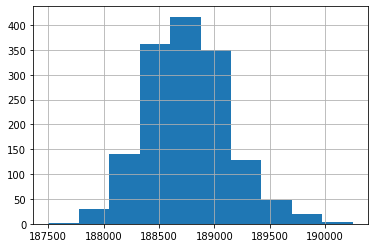

In [57]:
# Error will always be positive and integer, but is it skewed to the left?
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

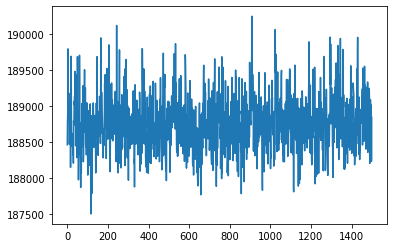

In [58]:
errors.plot()  # See if we still have a caterpillar

## 2.2.1 Beta sampling

### Task:

You must implement a function that receives matrices $C_i$ and vector $\alpha$ and generates the next $B_{i+1}$.

In [21]:
def MC_sample_B(alpha, C):
    # B, C are (k, V) -> Generate k vectors
    B = np.random.dirichlet(alpha + C[0,:], size=1)  # Topic 0
    for i in range(C.shape[0]-1):  # Go through topics: Fix is excluding topic 0 already generated
        B = np.concatenate((B, np.random.dirichlet(alpha + C[i+1,:], size=1)), axis=0)
    return B

## 2.2.2 Beta sampling tests

In [22]:
# Check that the function runs with no issues, without side effects
alpha = np.ones(V)
C_copy = test_data.C.copy()

B_sample = MC_sample_B(alpha, C_copy)

assert np.all(C_copy == test_data.C)

In [23]:
B_sample.shape  # k, V -> Fixed

(5, 12)

In [24]:
%%time
# Check that the Sampler works properly (This will take a while)
errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled B has {B_sample.size} words, while the target B has {test_data.B.size} words (diff {abs(B_sample.size-test_data.B.size)})')
for i in range(5000):
    B_sample_old = B_sample.copy()
    B_sample = MC_sample_B(alpha, C_copy)
    matrix_changes.append(~np.all(B_sample_old == B_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(B_sample - test_data.B))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch

The sampled B has 60 words, while the target B has 60 words (diff 0)
CPU times: user 306 ms, sys: 8.03 ms, total: 314 ms
Wall time: 312 ms


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

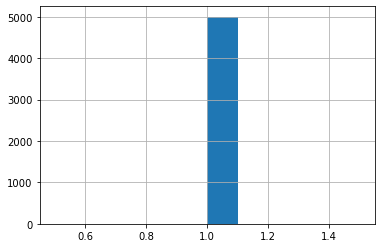

In [25]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean        0.329979
std         0.029698
min         0.228600
25%         0.309971
50%         0.328846
75%         0.349260
max         0.444858
dtype: float64


<AxesSubplot:>

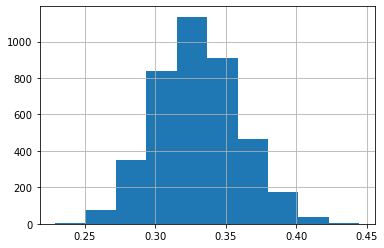

In [26]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

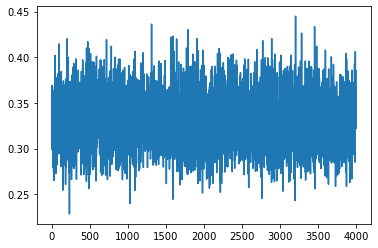

In [27]:
errors.plot()

## 2.3.1 Metropolis-Hastings MC Sampling

### Task:

You must implement a function that receives matrices $E_i$, $K_i$ and vector $\mu$ and generates the next $H_{i+1}$.


. $E$ matrix of $D \times k$ where $E_d$ is the $k$-dim vector of counts of sampled drawings for the $z$-th topic over all words for each document

. $K$ matrix of $k \times k$ representing the precision matrix associated to the graph $G$

. $\mu = 0$

. $H$ matrix of $D \times k$ where $H_d = \eta_d$ is the $k$-dim vector of the topic prevalences over document $d$

In [28]:
import numpy as np
import numpy.linalg

In [29]:
def sampled_distribution_kernel(eta, K, E):
    k = eta.shape[0]
    eta_K_eta = -0.5 * eta.dot(K.dot(eta))
    E_eta = E.dot(eta)
    sum_eta_pow_k = np.sum(np.exp(eta)) ** k
    return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706

In [30]:
def MC_sample_H(E, Sigma, H_current=None, burn_in=100, seed=None):
    
    np.random.seed(seed)
    
    K = np.linalg.inv(Sigma)
    
    D, k = E.shape  # Number of documents, Number of topics
    
    if H_current is None:
        H_current = np.zeros((D, k))
    
    H_sampled = np.zeros((D, k))
    
    for d in range(D):  # Iterating over each document
        current_eta = H_current[d]
        E_d = E[d]
        for iteration in range(burn_in + 1):
            
            # Sampling proposed eta from multivariate normal (q "proposal density")
            proposed_eta = np.random.multivariate_normal(current_eta, Sigma)
            
            # Compute acceptance probability
            p_proposed_eta = sampled_distribution_kernel(proposed_eta, K, E_d)
            p_current_eta = sampled_distribution_kernel(current_eta, K, E_d)
            if p_proposed_eta == np.inf or p_current_eta == 0:  # Avoiding divide by 0 and other numerical creeps
                alpha = 1
            else:
                alpha = min(1, p_proposed_eta / p_current_eta)
            
            if alpha == 1 or np.random.uniform(0.0, 1.0) < alpha:
                current_eta = proposed_eta
            
        H_sampled[d] = current_eta
    
    return H_sampled

## 2.3.2 MH Sampling Tests

In [31]:
E_copy = test_data.E.copy()
Sigma_copy = test_data.Sigma.copy()

H_sample = MC_sample_H(E_copy, Sigma_copy)

assert np.all(E_copy == test_data.E)
assert np.all(Sigma_copy == test_data.Sigma)

/tmp/ipykernel_111991/2545393832.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706


In [32]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000
for i in range(5000):
    H_sample_old = H_sample.copy()
    H_sample = MC_sample_H(E_copy, Sigma_copy, burn_in=1)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix

CPU times: user 9.05 s, sys: 14 µs, total: 9.05 s
Wall time: 9.07 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

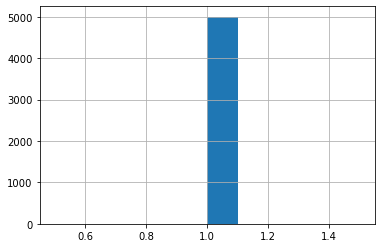

In [33]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean        8.791508
std         1.126076
min         5.635197
25%         7.983158
50%         8.693833
75%         9.492784
max        13.614358
dtype: float64


<AxesSubplot:>

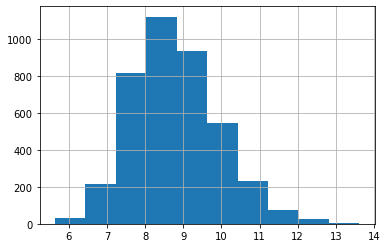

In [34]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

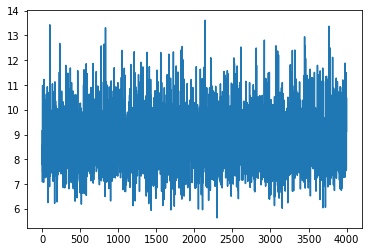

In [35]:
errors.plot()

## 2.4.1 BDMCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [ ]:
# R code, just for inspiration
#
#     # (K, G) parameters update and joint draw
#     data_BD = matrix(0,nrow = p, ncol = p)
#     for(i in 1:n){
#       data_BD = data_BD  + t(beta[[i]] - mu)%*%(beta[[i]] - mu)
#     }
#     if(iter != 1) {
#       fit = FGM::bdgraph(data = data_BD, n = n, method = 'ggm', algorithm = 'bdmcmc', iter = 1, burnin = 0,
#                     g.prior = gprior, df.prior = d0, g.start = fit$last_graph, save = T)
#     } else {
#       fit = FGM::bdgraph(data = data_BD, n = n, method = 'ggm', algorithm = 'bdmcmc', iter = 1, burnin = 0,
#                     g.prior = gprior, df.prior = d0, g.start = G0, save = T)
#     }
#     K = fit$last_K

In [169]:
import subprocess

def serialize_matrix(m):
    if len(m.shape) != 2:
        raise Exception("Can not serialize ill-shaped matrix!")
    res = '\n'.join(' '.join(str(entry) for entry in row)  # Space between entries, newline between rows
                     for row in m)
    return '"' + res + '"'

def deserialize_matrix(line, shape, separator=' '):
    return np.fromstring(line, sep=separator).reshape(shape)


def MC_sample_GK(G, K, H, degrees_of_freedom_b, debug=False):
    size = G.shape[0]
    n = H.shape[0]
    
    # Serialize the inputs
    G = serialize_matrix(G)
    K = serialize_matrix(K)
    
    # Transform H into the BDGraph data matrix
    data_matrix = H_sample.T.dot(H_sample)
    data_matrix = serialize_matrix(data_matrix)
    
    # call R script using python.subprocess
    # The parameter order is: deg.of freedom b, 
    #                         number of data samples (documents) n, 
    #                         graph adjacency matrix G, 
    #                         precision matrix K, 
    #                         data matrix,
    #                         debug ("TRUE" or "FALSE"), 
    command = f"Rscript --vanilla bdmcmc.R {b} {n} {G} {K} {data_matrix} {'TRUE' if debug else 'FALSE'}"
    result = subprocess.run(command, 
                            shell=True, 
                            capture_output=True,
                            text=True)
    
    if result.returncode != 0:  # Something went wrong
        print(result.stdout)
        print(result.stderr)
        raise Exception("Rscript error! Check the previous logs for more details")
    
    if debug:
        print(result.stdout)
    
    # The last two lines of the R output MUST be the sampled matrices
    lines = result.stdout.rsplit('\n', 3)  # Split only the last three lines  https://www.w3schools.com/python/ref_string_rsplit.asp
    waiting_time = float(lines[-3])  # 3rd from the end
    G = deserialize_matrix(lines[-2], shape=(size, size))  # Line before last
    K = deserialize_matrix(lines[-1], shape=(size, size))  # Last line
    return waiting_time, G, K

#### MC_sample_G tests

In [172]:
# Check that the function runs with no issues, without side effects
G_copy = random_initial_data.G.copy()
K_copy = random_initial_data.K.copy()
H_copy = test_data.H.copy()
degrees_of_freedom_b = k - 1
shape_matrix = np.eye(k)

wt_sample, G_sample, K_sample = MC_sample_GK(G_copy, K_copy, H_copy, degrees_of_freedom_b, debug=True)

# assert np.all(W_copy == test_data.W)
# assert np.all(Z_copy == test_data.Z)
# assert np.all(H_copy == test_data.H)
# assert np.all(K_copy == test_data.K)
# assert np.all(E_copy == test_data.E)
# assert np.all(shape_matrix == np.eye(k))

[1] "[R] Matrix G:"
     V1 V2 V3 V4 V5
[1,]  0  0  0  0  0
[2,]  0  0  0  0  0
[3,]  0  0  0  0  0
[4,]  0  0  0  0  0
[5,]  0  0  0  0  0
[1] "[R] Matrix K:"
     V1 V2       V3        V4 V5
[1,]  1  0  0.00000  0.000000  0
[2,]  0  1  0.00000  0.000000  0
[3,]  0  0  1.00000 -0.797880  0
[4,]  0  0 -0.79788  1.636612  0
[5,]  0  0  0.00000  0.000000  1
[1] "[R] Data Matrix:"
           V1        V2       V3        V4        V5
[1,] 5767.931  4061.248 3417.288  4083.357  4860.489
[2,] 4061.248  9762.239 3944.943  8351.152 10753.449
[3,] 3417.288  3944.943 7080.370  4746.036  6007.360
[4,] 4083.357  8351.152 4746.036 10810.826 13222.263
[5,] 4860.489 10753.449 6007.360 13222.263 17476.518
[1] "[R] Shape Matrix:"
     [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0    0    0
[2,]    0    1    0    0    0
[3,]    0    0    1    0    0
[4,]    0    0    0    1    0
[5,]    0    0    0    0    1
[1] "[R] Waiting time:"
[1] 0.45
[1] "[R] Sampled Matrix G:"
     V1 V2 V3 V4 V5
[1,]  0  0  0  0

# OLD CODE BELOW. TESTS MUST BE REVIEWED TOO

### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [38]:
import subprocess

# Remember to install BDgraph package version 2.62 on your R environment
# You'll need to run the following commands:
# remove.packages("BDgraph")
# install.packages("remotes")
# library(remotes)
# install_version("BDgraph", "2.62")


def MC_sample_K(G, b, shape_matrix, n_of_samples, debug=False):
    # save G to csv
    np.savetxt("adj.csv", G, delimiter=",")
    # save shape_matrix to csv (OR pass them as parameters to RScript)
    np.savetxt("shape.csv", shape_matrix, delimiter=",")
    # call R script using python.subprocess
    result = subprocess.run(f"Rscript --vanilla rgwish.R {b} {n_of_samples} {'TRUE' if debug else 'FALSE'}", shell=True) # -> HOW MANY SAMPLES ARE REQUIRED? SHOULD THIS ALSO BE VARIABLE AND THEREFORE PASSED TO R?
    if result.returncode != 0:
        raise Exception("Rscript error! Check the previous logs for more details")

    # read the results from csv (OR get the result back from R script)
    
    # Always better to open file handlers within a "with" statement (otherwise you must take care of closing the file)
    with open("gwish.csv", "r") as csv_file:  
        K = np.loadtxt(csv_file, delimiter=",")
    
    return K

In [37]:
# def MC_sample_G(W, Z, H, K, G, E, dof, shape):

#     N = G.shape[0]
#     delta_K = 0
#     beta_K = 0

#     death_rates = np.zeros((k,k))
#     birth_rates = np.zeros((k,k))
    
#     n = D  # It's either of the shape indices of H
#     # from the paper I'm not sure yet which but looks the docs for us
    
#     S = shape  # prior parameter
#     b = dof  # prior parameter

#     PrHK = lambda K, H:        K.size ** (n / 2) * np.exp(-0.5 * np.trace(np.matmul(np.matmul(K, H.T), H)))
#     PrK_G = lambda K, G, D, b: K.size ** (b + D - 2) * np.exp(-0.5 * np.trace(np.matmul(S + np.matmul(H.T, H), K)))
#     PrG = lambda gamma, E:  (gamma / (1 - gamma)) ** (E.size)
#     PrKG_H = lambda K, G, H, D, b, gamma, E: PrHK(K, H) * PrK_G(K, G, D, b) * PrG(gamma, E)

#     Pr_init = PrKG_H(K, G, H, D, k - 1, gamma, E)

#     for i in range(N):
#         for j in range(i + 1, N):
#             if G[i,j]:
#                 G_loop = G.copy()
#                 G_loop[i,j] = 0
#                 G_loop[j,i] = 0
#                 #technically, we should compute K_loop here...
#                 Pr_loop = PrKG_H(K,G_loop,H,D,b,gamma,E)

#                 death_rate = Pr_loop / Pr_init

#                 if death_rate > 1:
#                     death_rate = 1
#                 death_rates[i,j] = death_rate
#                 death_rates[j,i] = death_rate
#                 delta_K += death_rate

#             else:
#                 G_loop = G.copy()
#                 G_loop[i,j] = 1
#                 G_loop[j,i] = 1
#                 #technically, we should compute K_loop here...
#                 Pr_loop = PrKG_H(K, G_loop, H, D, b, gamma, E) 

#                 birth_rate = Pr_loop / Pr_init

#                 if birth_rate > 1:
#                     birth_rate = 1
#                 birth_rates[i,j] = birth_rate
#                 birth_rates[j,i] = birth_rate
#                 beta_K += birth_rate
    
#     W = 1/(beta_K + delta_K)

#     pr_death = W * death_rates
#     pr_birth = W * birth_rates

#     G[pr_death > 0.5] = 0
#     G[pr_birth > 0.5] = 1
   
#     return G

In [3]:
def Pr_G(n_of_links, p_of_existing_link_theta):
    """Probability kernel of having a graph with n links, given theta prior of existing link
        
    """
    return (p_of_existing_link_theta / (1 - p_of_existing_link_theta)) ** n_link


def Pr_K_given_G(degrees_of_freedom_b, shape_matrix_D=None, K=None, norm_of_K=None, trace_of_DK=None):
    """Probability kernel of precision matrix K given graph G with prior G-Wishart(b, D)
        
    """
    # IMPORTANT: I'm assuming K belongs to the cone defined by G. Therefore G is NOT needed as parameter
    # IMPORTANT: I am returning a kernel, therefore NOT computing the normalization constant.
    
    norm_of_K = norm_of_K or np.linalg.norm(K) # norm of K can be precomputed to speed up the process
    trace_of_DK = trace_of_DK or np.trace(shape_matrix_D * K) # trace of K can be precomputed to speed up the process
    return (norm_of_K ** ((degrees_of_freedom_b - 2) / 2)) * np.exp(-0.5 * trace_of_DK)


def Pr_Z_given_K(U=None, K=None, sample_size_n=None, norm_of_K=None, trace_of_KU=None):
    """Probability kernel of gaussian data matrix Z of n samples given precision matrix K
    
    Note that you must pass U = Z'Z to avoid repeated computation
    
    The article defines P(Z|K, G), but G dependence is actually implicit
    """
    norm_of_K = norm_of_K or np.linalg.norm(K) # norm of K can be precomputed to speed up the process
    trace_of_KU = trace_of_KU or np.trace(K * U) # tr(KU) can be precomputed to speed up the process
    return (norm_of_K ** (sample_size_n / 2)) * np.exp(-0.5 * trace_of_KU)

def MC_sample_G(G, K, multivariate_gaussian_data_matrix_Z, degrees_of_freedom_b,  p_of_existing_links=0.5):
    
    # K must belong to the cone defined by G:
    # if this exception is never raised in real life, you may comment it out to speed up code
    if not np.sum((K - np.diag(np.diag(K)) != 0) - G) == 0: 
        raise Exception("K matrix does not belong to the cone defined by G!")
    
    # Local variables and pre-computed values
    n_of_links = int(G.sum() / 2)
    k = G.shape[0]  # Number of topics. Also, size of matrix.
    sample_size = multivariate_gaussian_data_matrix_Z.shape[0]
    U = multivariate_gaussian_data_matrix_Z.T * multivariate_gaussian_data_matrix_Z
    norm_of_K = np.norm(K)
    trace_of_KU = np.trace(K * U)
    trace_of_DK = np.trace(shape_matrix_D * K)
    
    p_G = Pr_G(n_of_links=n_of_links, 
               p_of_existing_link_theta=p_of_existing_links)
    p_Gminus = Pr_G(n_of_links=n_of_links - 1, 
                    p_of_existing_link_theta=p_of_existing_links)
    p_Gplus = Pr_G(n_of_links=n_of_links + 1, 
                    p_of_existing_link_theta=p_of_existing_links)
    
    p_K_given_G = Pr_K_given_G(degrees_of_freedom_b=degrees_of_freedom_b, 
                               norm_of_K=norm_of_K,
                               trace_of_DK=trace_of_DK)
    p_Z_given_K = Pr_Z_given_K(sample_size_n=sample_size, 
                               trace_of_KU=trace_of_KU, 
                               norm_of_K=norm_of_K)
    p_G_K_given_Z = p_Z_given_K * p_K_given_G * p_G
    
#     1.1+2. Calculate the birth and death rates
    BD_prob = np.zeros((k, k))  # This will hold birth and death probabilities (using G as a selection mask)
    for i in range(k):
        for j in range(i + 1, k):  # Matrix is symmetric and diagonal is 0
            if G[i, j] != 0:  # Link exists
                Gminus = G.copy()
                Kminus = K.copy()  
                
                # Removing edge
                Gminus[i, j] = Gminus[j, i] = Kminus[i, j] = Kminus[j, i] = 0  # I love python!
                # TODO: What should I put in Kminus[i, i] and Kminus[j, j] ?
                # See https://projecteuclid.org/journals/bayesian-analysis/volume-10/issue-1/Bayesian-Structure-Learning-in-Sparse-Gaussian-Graphical-Models/10.1214/14-BA889.full
                norm_of_Kminus = np.norm(Kminus)
                
                p_Z_given_Kminus = Pr_Z_given_K(U=U, 
                                                K=Kminus, 
                                                sample_size_n=sample_size, 
                                                norm_of_K=norm_of_Kminus)
                p_Kminus_given_Gminus = Pr_K_given_G(degrees_of_freedom_b=degrees_of_freedom_b,
                                                     shape_matrix_D=shape_matrix_D,
                                                     K=Kminus,
                                                     norm_of_K=norm_of_Kminus)
                
                BD_prob[i, j] = BD_prob[j, i] = (p_Z_given_Kminus * p_Kminus_given_Gminus * p_Gminus)
                
            else:  # Link does not exist
                Gplus = G.copy()
                Kplus = K.copy()  
                
                Gplus[i, j] = Gplus[j, i] = 1  # Adding edge
                
                # TODO: I am just assigning a random value between 0 and 1 to the entry in the precision matrix
                # Does it make sense?
                Kplus[i, j] = Kplus[j, i] = np.random.random()
                # TODO: What should I put in Kplus[i, i] and Kplus[j, j] ?
                # See https://projecteuclid.org/journals/bayesian-analysis/volume-10/issue-1/Bayesian-Structure-Learning-in-Sparse-Gaussian-Graphical-Models/10.1214/14-BA889.full
                norm_of_Kplus = np.norm(Kplus)
                
                p_Z_given_Kplus = Pr_Z_given_K(U=U, 
                                               K=Kplus, 
                                               sample_size_n=sample_size, 
                                               norm_of_K=norm_of_Kplus)
                p_Kplus_given_Gplus = Pr_K_given_G(degrees_of_freedom_b=degrees_of_freedom_b,
                                                   shape_matrix_D=shape_matrix_D,
                                                   K=Kplus,
                                                   norm_of_K=norm_of_Kplus)
                
                BD_prob[i, j] = BD_prob[j, i] = (p_Z_given_Kplus * p_Kplus_given_Gplus * p_Gplus)
    
    BD_prob = np.minimum(BD_prob / p_G_K_given_Z, 1)  # min between ratio and 1
    beta_K = BD_prob[~G].sum() / 2  # Selecting edges NOT in G and summing them: overall BIRTH ratio
    delta_K = BD_prob[G].sum() / 2  # Selecting edges in G and summing them: overall DEATH ratio

#     1.3. Calculate the waiting time (which is the inverse of the sum of the ratios)    
    W_K = 1 / (beta_K + delta_K)  # Waiting time. This MUST be returned
    
    BD_prob *= W_k  # actual Birth-Death probability matrix 
    
#     1.4. Simulate the type of jump (birth or death) 
    # TODO: This part is missing. See https://projecteuclid.org/journals/bayesian-analysis/volume-10/issue-1/Bayesian-Structure-Learning-in-Sparse-Gaussian-Graphical-Models/10.1214/14-BA889.full
    # It is not clear how to chose which edge(s) to add / remove. One at a time? ...

## 2.4.2 BDMCMC Sampling Tests

#### MC_sample_K tests

In [38]:
#This is a basic test of MC_sample_K
G = [[0,0,1,0,0],
     [0,0,0,0,0],
     [1,0,0,0,0],
     [0,0,0,0,0],
     [0,0,0,0,0]]
shape_matrix = np.eye(5, dtype=int)
K_sample = MC_sample_K(G, 5, shape_matrix, n_of_samples=1)

assert np.all(shape_matrix == np.eye(5, dtype=int))

In [39]:
#This is a basic test of MC_sample_K
G_copy = test_data.G.copy()
shape_matrix = np.eye(k, dtype=int)
b = k - 1
K_sample = MC_sample_K(G_copy, b, shape_matrix, n_of_samples=1, debug=True)

assert np.all(G_copy == test_data.G)
assert np.all(shape_matrix == np.eye(k, dtype=int))

[1] "[R] rgwish will now be sampling 1 samples. The b (degrees of freedom) is set to 4"
[1] "[R] rgwish succesfully executed!"


In [40]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 0
for i in range(1000):
    K_sample_old = K_sample.copy()
    K_sample = MC_sample_K(G_copy, b, shape_matrix, n_of_samples=1, debug=False)
    matrix_changes.append(~np.all(K_sample_old == K_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(K_sample - test_data.K))  # Computing error wrt the target matrix

CPU times: user 1.16 s, sys: 3.07 s, total: 4.23 s
Wall time: 2min 12s


Matrix changes (1 = changed, 0 = same)
count    1000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

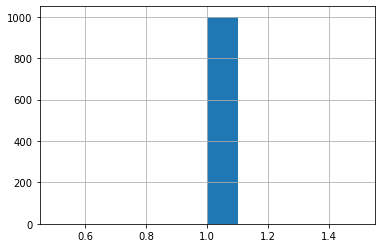

In [41]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    1000.000000
mean        8.263602
std         3.803911
min         1.368047
25%         5.260115
50%         7.842345
75%        10.478852
max        24.497483
dtype: float64


<AxesSubplot:>

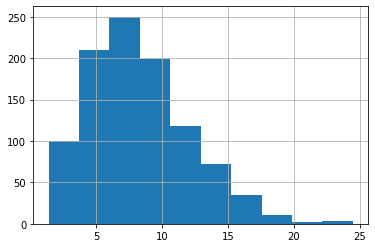

In [42]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

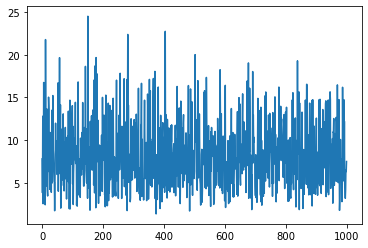

In [43]:
errors.plot()

In [44]:
G

[[0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [45]:
shape_matrix

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

#### MC_sample_G tests

In [46]:
# Check that the function runs with no issues, without side effects
W_copy = test_data.W.copy()
Z_copy = test_data.Z.copy()
H_copy = test_data.H.copy()
K_copy = test_data.K.copy()
G_copy = random_initial_data.G.copy()
E_copy = test_data.E.copy()
b = k - 1
shape_matrix = np.eye(k)

G_sample = MC_sample_G(W_copy, Z_copy, H_copy, K_copy, G_copy, E_copy, b, shape_matrix)

assert np.all(W_copy == test_data.W)
assert np.all(Z_copy == test_data.Z)
assert np.all(H_copy == test_data.H)
assert np.all(K_copy == test_data.K)
assert np.all(E_copy == test_data.E)
assert np.all(shape_matrix == np.eye(k))

In [47]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000
for i in range(5000):
    G_sample_old = G_sample.copy()
    G_sample = MC_sample_G(W_copy, Z_copy, H_copy, K_copy, G_sample, E_copy, b, shape_matrix)
    matrix_changes.append(~np.all(G_sample_old == G_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(G_sample - test_data.G))  # Computing error wrt the target matrix

CPU times: user 1.62 s, sys: 24.8 ms, total: 1.65 s
Wall time: 1.61 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64


<AxesSubplot:>

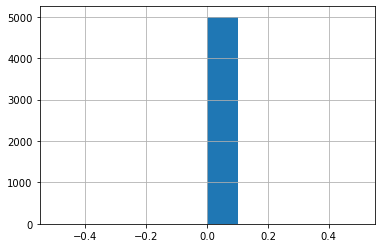

In [48]:
# Matrix should change  # BUG https://trello.com/c/2K64NaeG/28-mcsampleg-g-matrix-is-never-updated
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64


<AxesSubplot:>

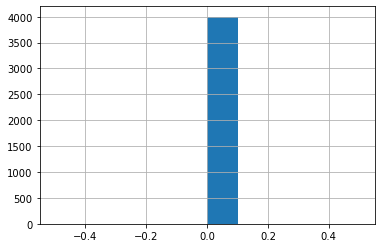

In [49]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

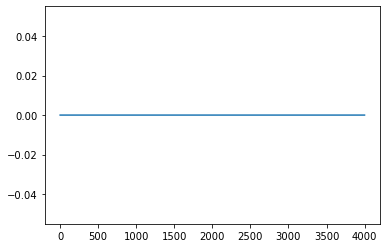

In [50]:
errors.plot()

# MAIN ALGORITHM

### Generating Data

In [ ]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1984)
simulated_data.generate_all_data()

In [ ]:
# Input Data:
simulated_data.W

# SAMPLER

In [ ]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

In [15]:
import matplotlib.pyplot as plt

In [ ]:
max_iteration = 100

# Data
W = simulated_data.W

# Initialization
Sigma = initial.Sigma
K = np.linalg.inv(Sigma)
B = initial.B
Theta = initial.Theta
G = initial.G

alpha = np.ones(V)  # Uninformative prior
b = k - 1
shape_matrix = np.eye(k)

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z


for iteration in range(max_iteration):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, W, Theta, B, E, C)  # They are already updated in the algorithm
    #E = update_E(E, Z)  # get E from Z
    #C = update_C(C, Z)  # get C from Z ...
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4
    b += D  # add D since it's the amount of etas we have
    shape_matrix += np.matmul(H.T, H)  # Add H^T H (matrix product)
    
    G_new = MC_sample_G(W, Z, H, K, G, E, b, shape_matrix)
    if np.all(G_new == G):
        print('G matrix has NOT changed!')
    G = G_new
    
    K = MC_sample_K(G, b, shape_matrix, n_of_samples=1)
    Sigma = np.linalg.inv(K)
    
    # Hope for convergence!
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}")
    
    if iteration%10==0:  # Plot every 10 iterations
        df = pd.DataFrame(G)
        plt.pcolor(df > 0.5, cmap='Blues')
        plt.show()

In [ ]:
H.shape

In [ ]:
shape_matrix.shape

In [ ]:
b